In [1]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=6f7f6ae4293939c4a221ce4b6fce421f07b3f190c844f09f787f3c20cc2894ce
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [10]:
from operator import itemgetter
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, models
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from IPython.display import clear_output
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn import TripletMarginLoss
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/train.csv', index_col=0)

df['Keys'] = df['Keys'].apply(eval)
df['skills'] = df['Keys'].apply(lambda x: 'Требуемые навыки: ' + ', '.join(x))
df['Specializations'] = df['Specializations'].apply(eval)
df['Specializations'] = df['Specializations'].apply(lambda x: ', '.join(x))
df['job_description'] = df['Description'] + ' ' +  df['skills'] + ' ' + df['Specializations'] + '. Требуемый опыт:' + df['Experience']

df['resume_description'] = 'Ищет работу на должность: ' + df['Ищет работу на должность:'] +' ' + df['Опыт работы'] + ' ' + df['Образование и ВУЗ']

In [5]:
df.iloc[0]['job_description']

'В рамках направления «Развитие открытых API» на площадке Ассоциации ФинТех ведется работа по обеспечению недискриминационного доступа провайдеров услуг к финансовой инфраструктуре, что способствует созданию и развитию конкурентного, качественного и экономически эффективного рынка финансовых услуг. Ассоциация ФинТех совместно с ключевыми участниками финансового рынка занимается подготовкой стандартов и механизмов внедрения открытых API, прорабатываются требования к информационной безопасности и моделям данных, а так же рассматриваются варианты продвижения и популяризации среды открытых API. Внедрение стандартов открытых API позволит повысить скорость, качество и уровень безопасности продуктов и услуг, предоставляемых провайдерами услуг на основе открытых API и финансовыми организациями, а также построить современную цифровую финансовую систему. В среде открытых API на равных условиях смогут конкурировать традиционные финансовые институты и финтех-компании, а клиенты получат более быстр

## Training utils

In [6]:
class TripletDataset(Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        vacancy = self.data.iloc[index]['job_description']
        positive_cv = self.data.iloc[index]['resume_description']
        negative_cv = self._sample_negative(index)

        return vacancy, positive_cv, negative_cv

    def _sample_negative(self, index):
        vacancy_name = self.data.iloc[index]['Name']
        negative_row = self.data.sample()

        while negative_row["Name"].item() == vacancy_name:
            negative_row = self.data.sample()

        return negative_row['resume_description'].item()


In [7]:
def collate_fn(batch):
    vacancies = list(map(itemgetter(0), batch))
    positives = list(map(itemgetter(1), batch))
    negatives = list(map(itemgetter(2), batch))

    return vacancies, positives, negatives

## Training

In [8]:
model_path = "distiluse-base-multilingual-cased-v1"
weights_path = "/content/drive/MyDrive/ce_model"
batch_size = 64
margin = 0.75
lr = 1e-4
device = torch.device("cuda")
verbose = 2

In [9]:
def get_base_model(model_path):
    model = SentenceTransformer(model_path)

    return model


model = get_base_model(model_path)

model.to(device)
model.train()

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.45k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [12]:
class ContrastiveCrossEntropy(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin

    def forward(self, vac_emb: torch.Tensor, pos_emb: torch.Tensor, neg_emb: torch.Tensor) -> torch.Tensor:
        pos_scores = (vac_emb * pos_emb).sum(dim=1)
        neg_scores = (vac_emb * neg_emb).sum(dim=1)

        loss_val = torch.exp(neg_scores + self.margin) - pos_scores
        loss_val[loss_val < 1] = 1

        return loss_val.log().mean()

In [13]:
loss = ContrastiveCrossEntropy(margin=margin)
optimizer = AdamW(model.parameters(), lr=lr)

dataloader = DataLoader(TripletDataset(df), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [14]:
def get_embeddings(input, normalize=False):
    out = model(input)['sentence_embedding']

    if normalize:
        out = F.normalize(out, dim=-1)

    return out

def to_device(tokens):
    return {k: v.to(device) for k, v in tokens.items()}

def show_loss(losses):
    fig, ax = plt.subplots()
    idx = list(range(len(losses)))

    ax.plot(idx, losses)
    fig.tight_layout()

    clear_output(wait=True)
    display.display(fig)

In [15]:
def train_epoch():
    losses = []

    for i, (vacancies, positives, negatives) in tqdm(enumerate(dataloader), total=len(dataloader)):
        vac_emb = get_embeddings(to_device(model.tokenize(vacancies)))
        pos_emb = get_embeddings(to_device(model.tokenize(positives)))
        neg_emb = get_embeddings(to_device(model.tokenize(negatives)))

        l = loss(vac_emb, pos_emb, neg_emb)
        l.backward()
        losses.append(l.item())

        if (i + 1) % verbose == 0:
            show_loss(losses)

        optimizer.step()
        optimizer.zero_grad()

    print(f"epoch loss: {(sum(losses) / len(losses)):3f}")

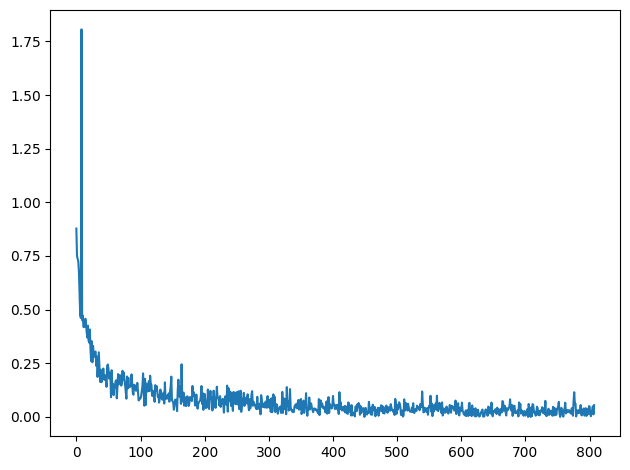

 22%|██▏       | 808/3675 [14:23<51:04,  1.07s/it]


KeyboardInterrupt: ignored

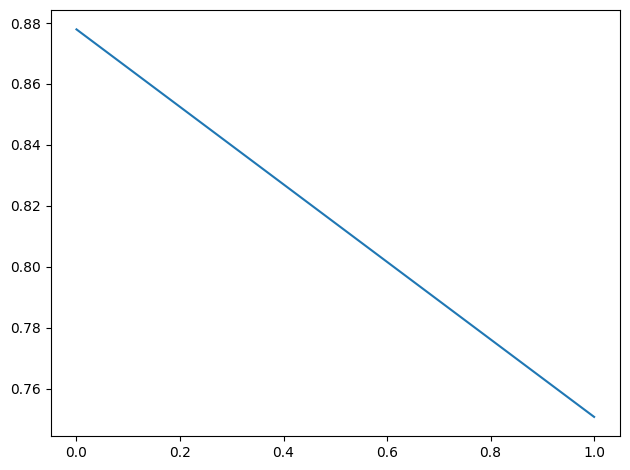

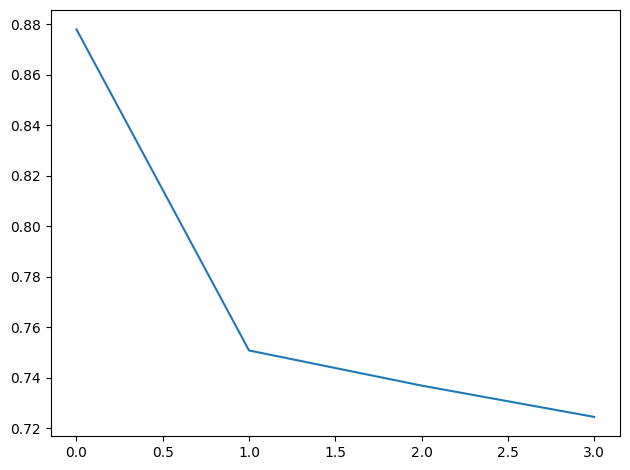

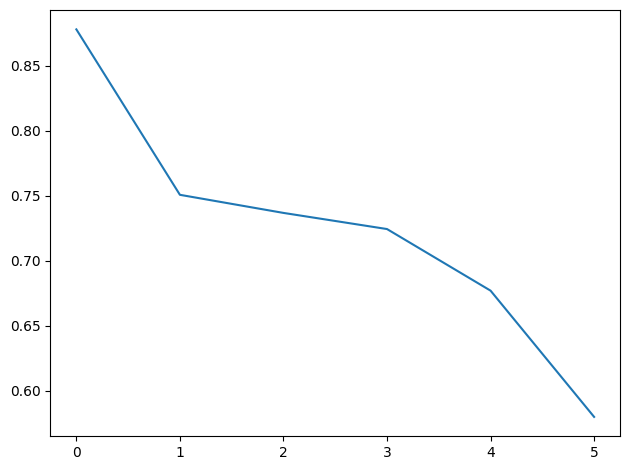

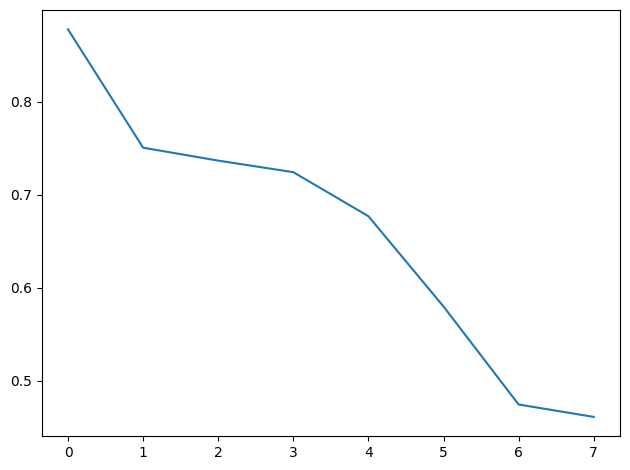

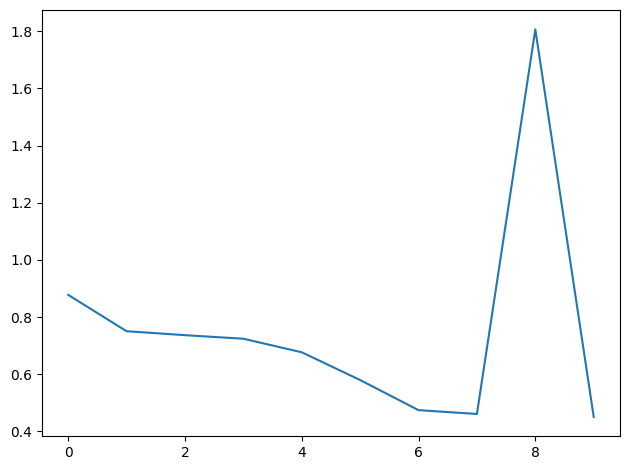

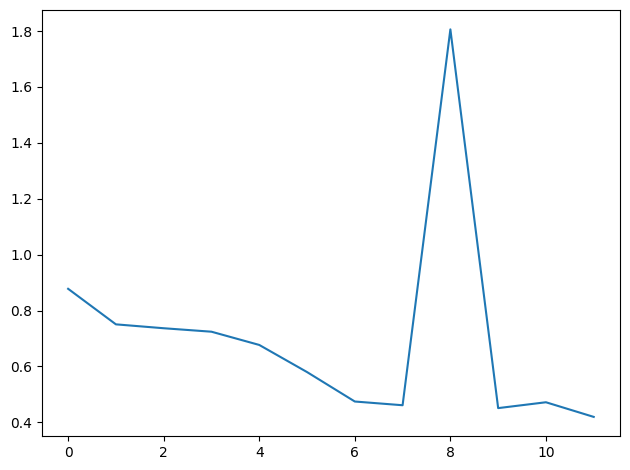

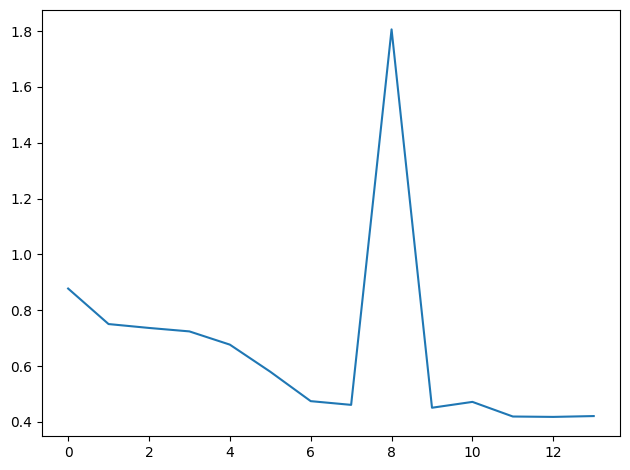

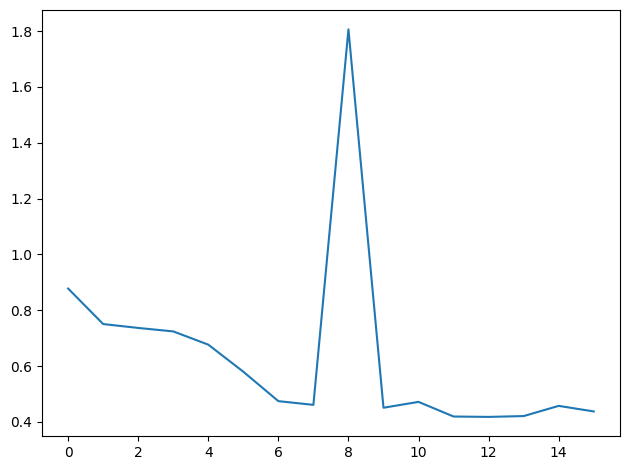

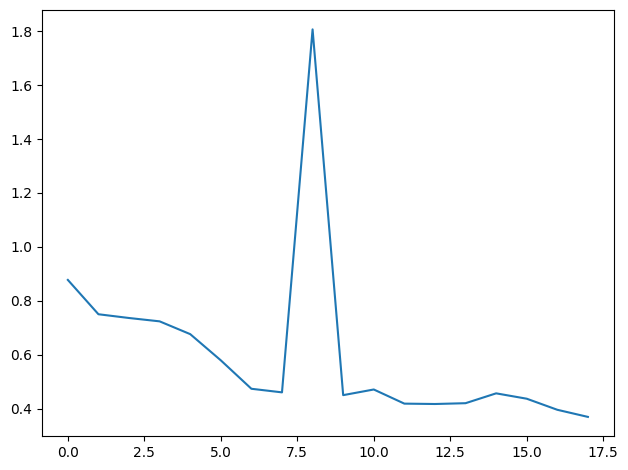

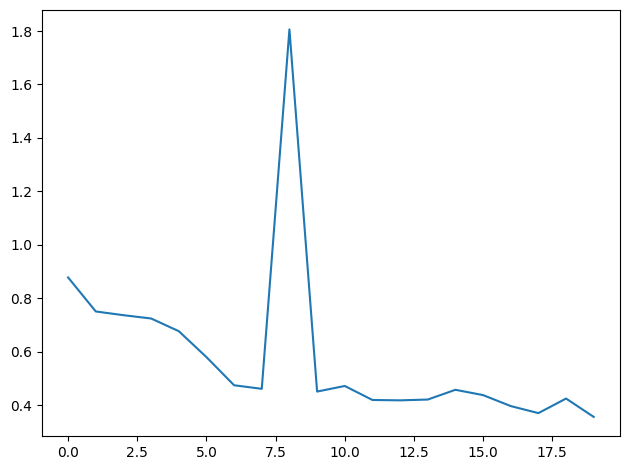

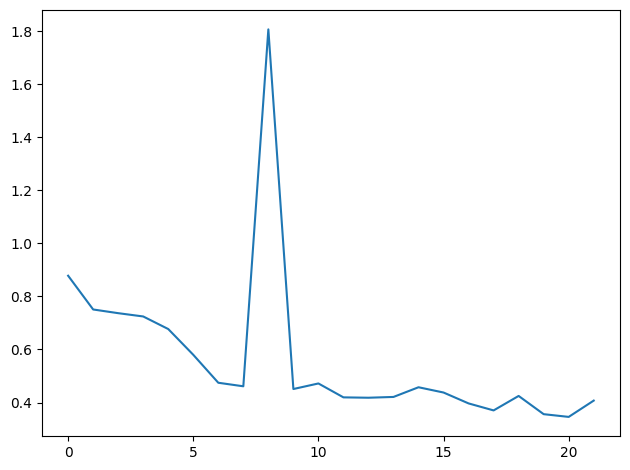

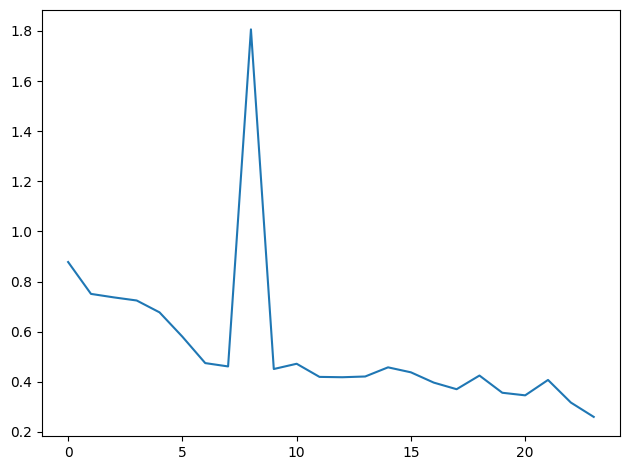

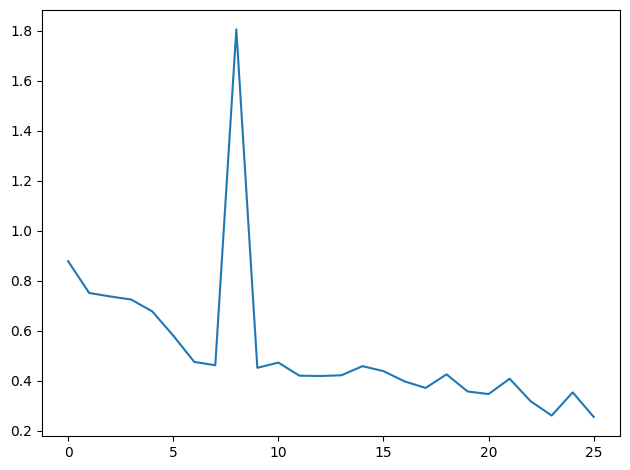

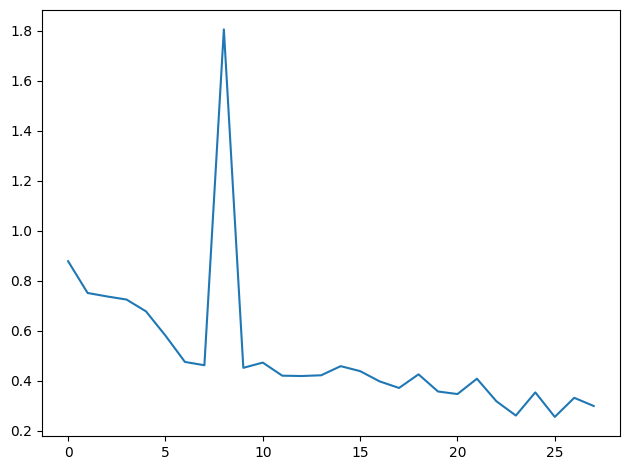

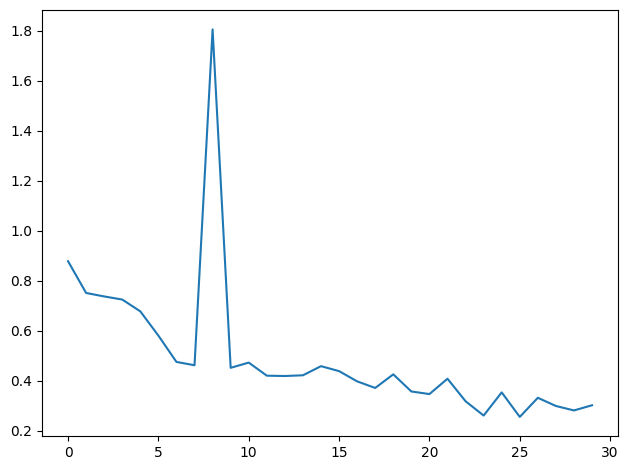

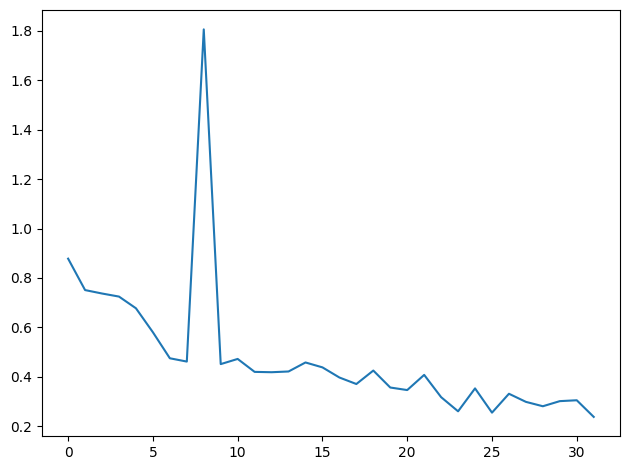

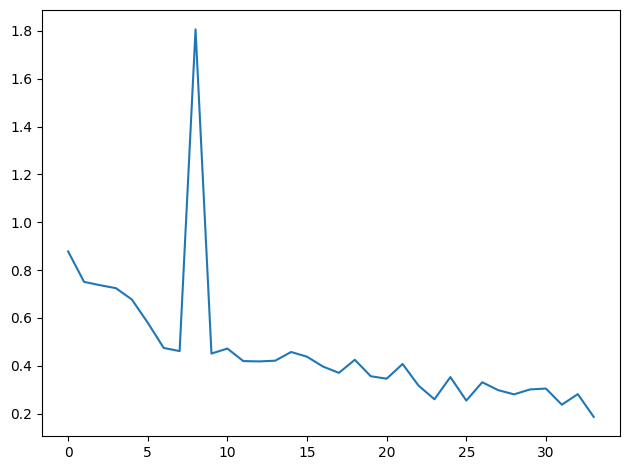

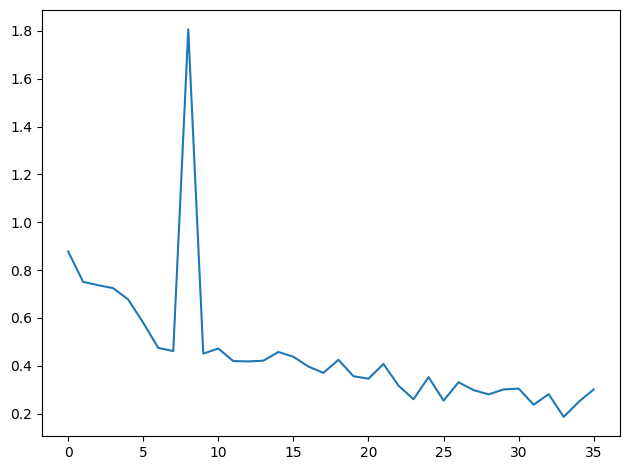

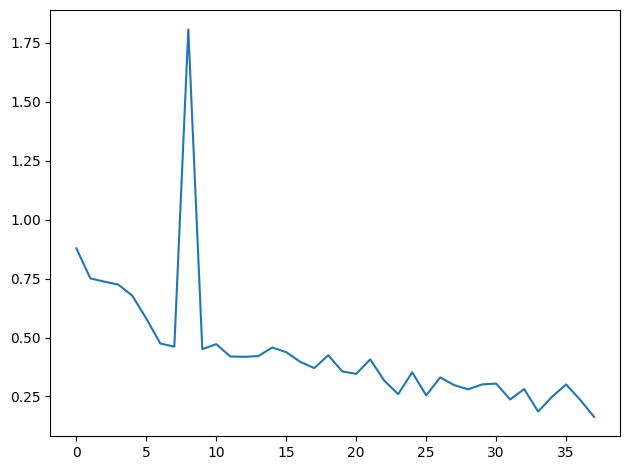

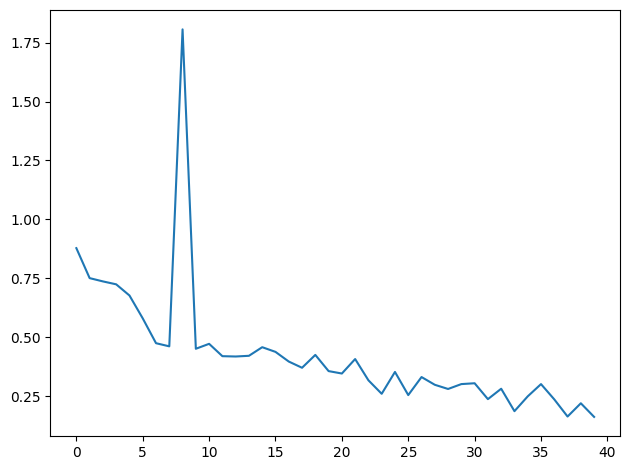

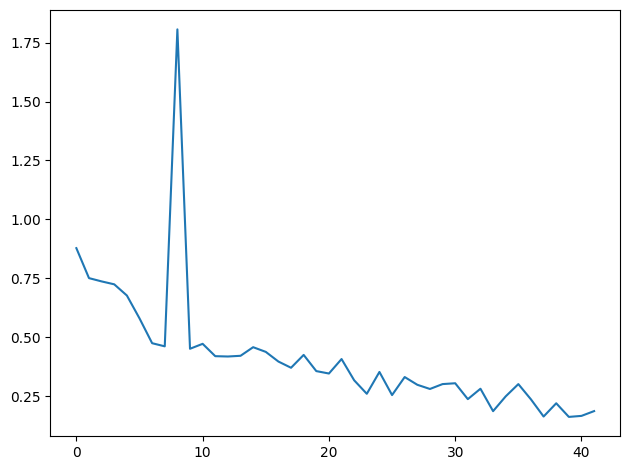

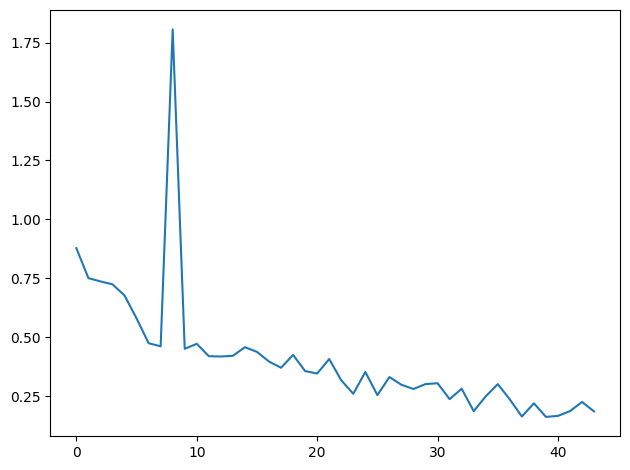

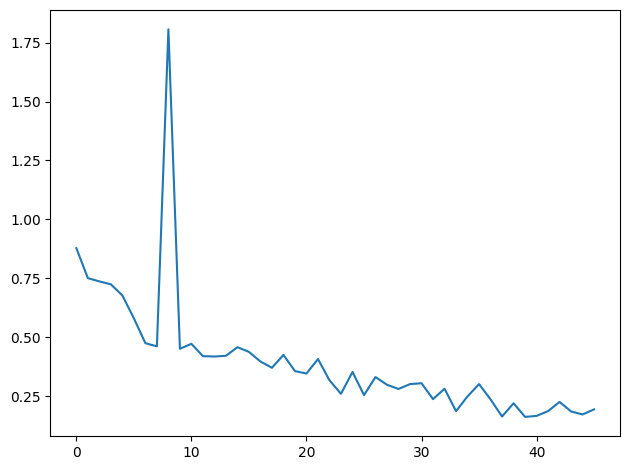

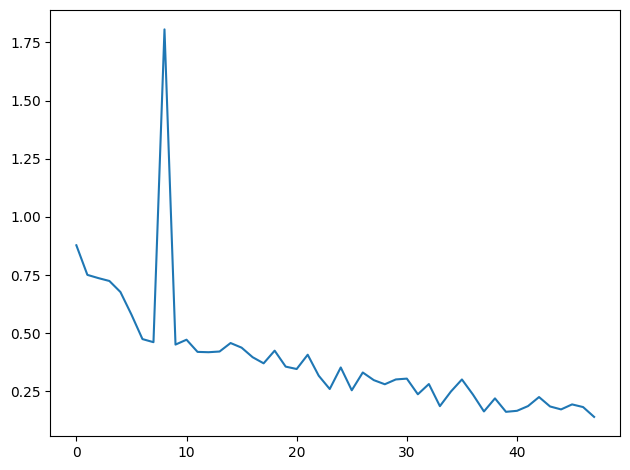

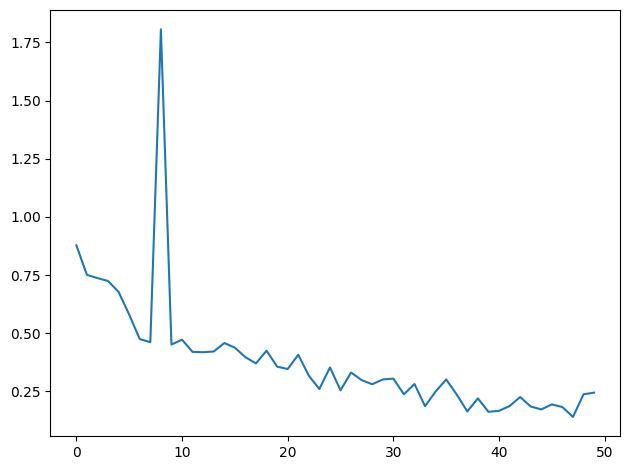

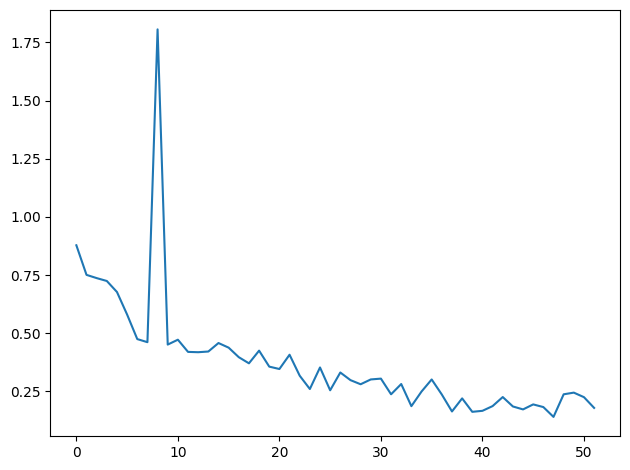

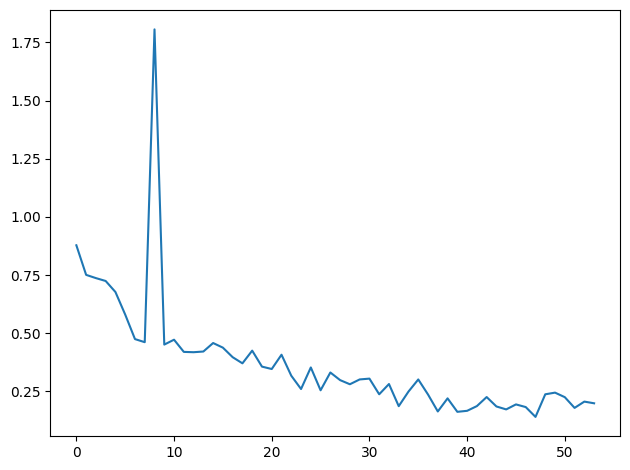

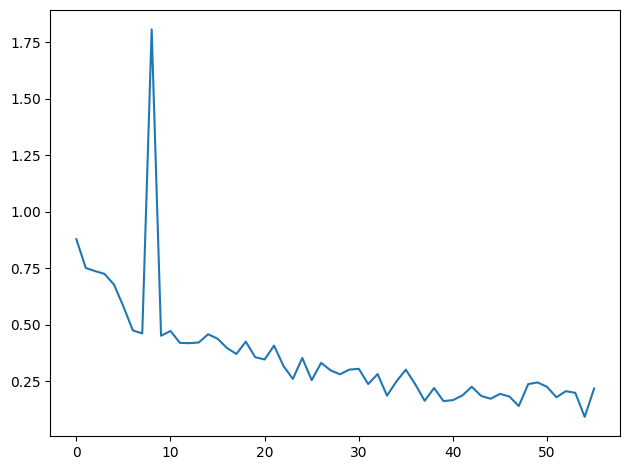

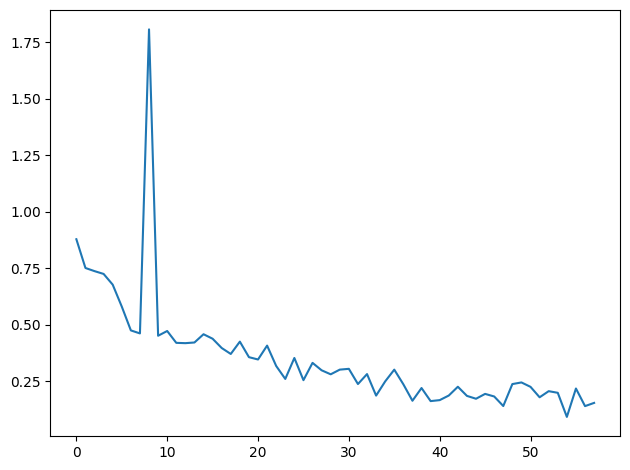

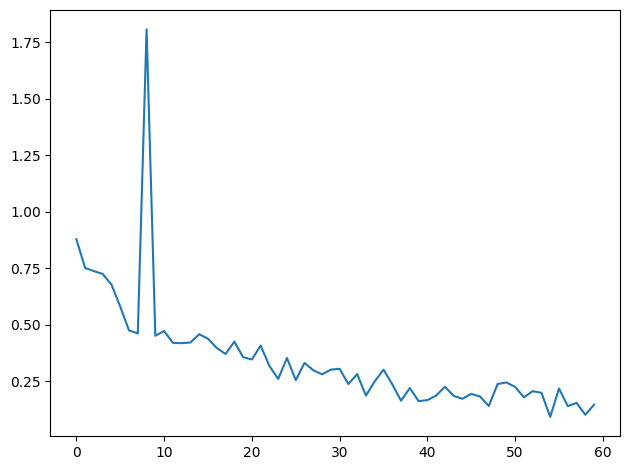

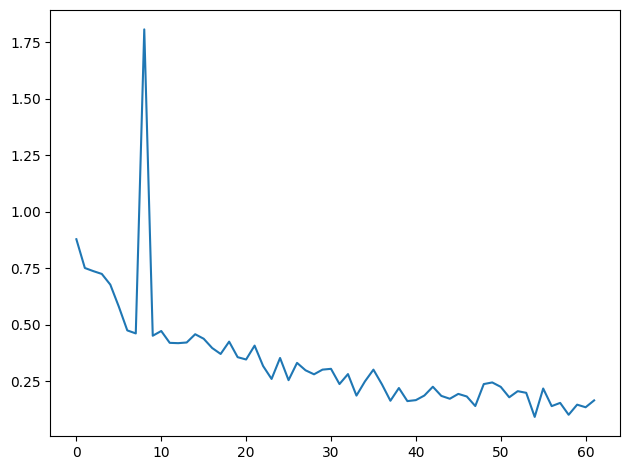

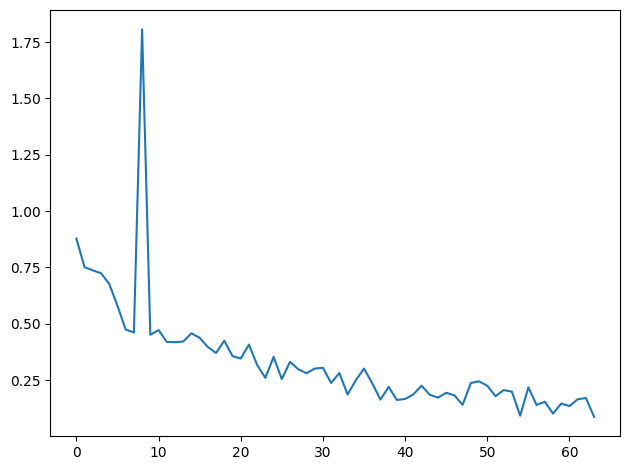

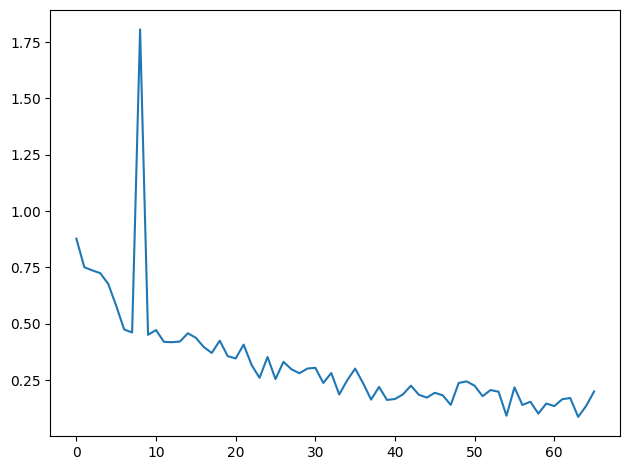

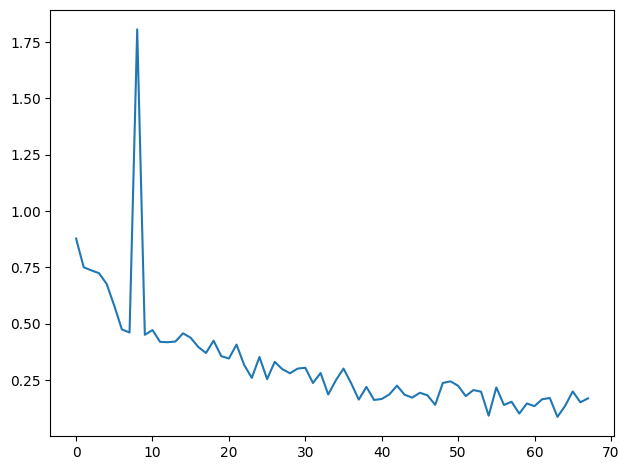

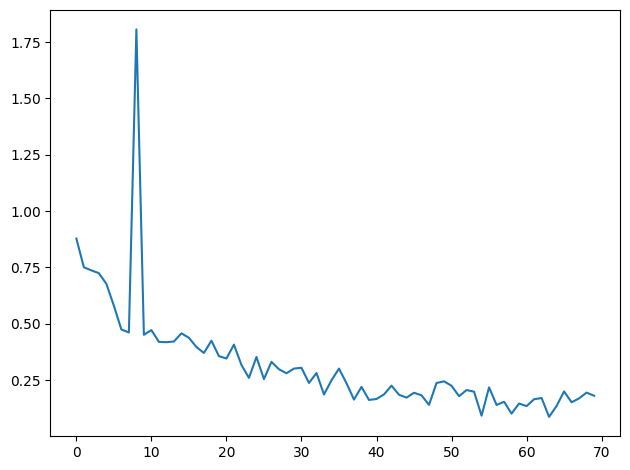

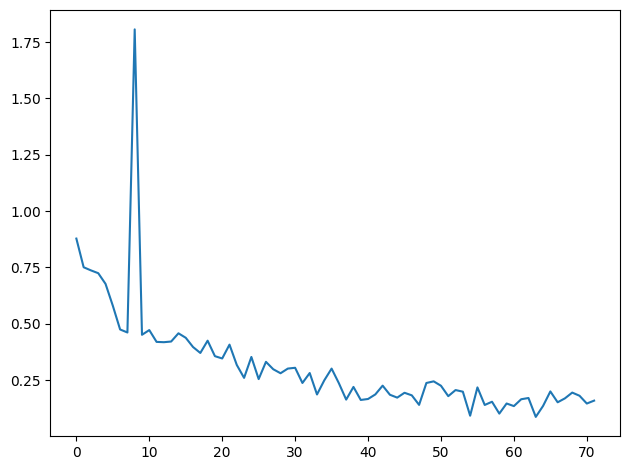

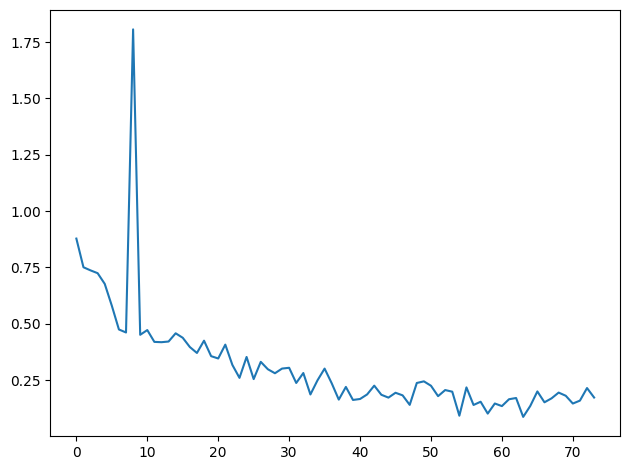

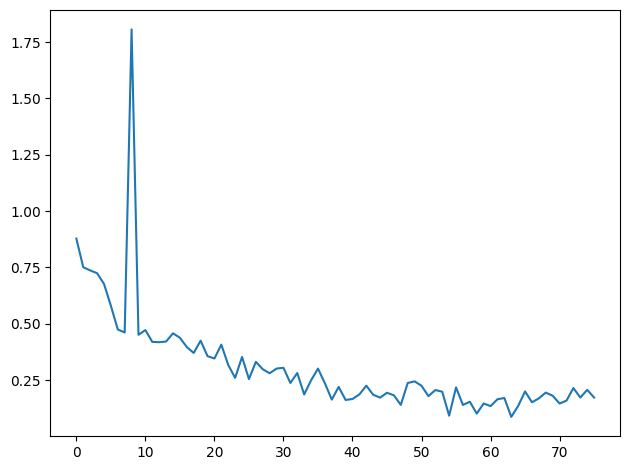

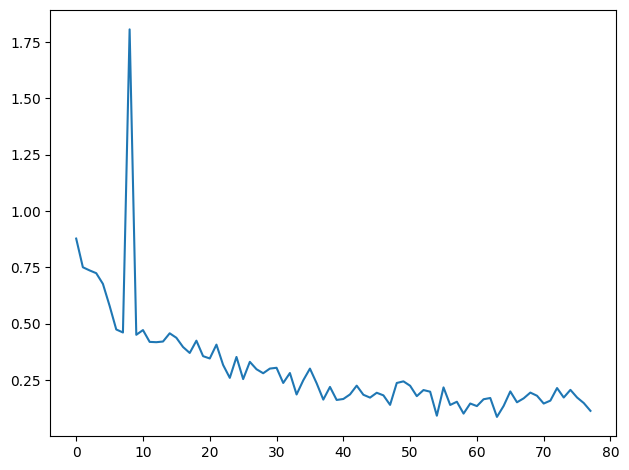

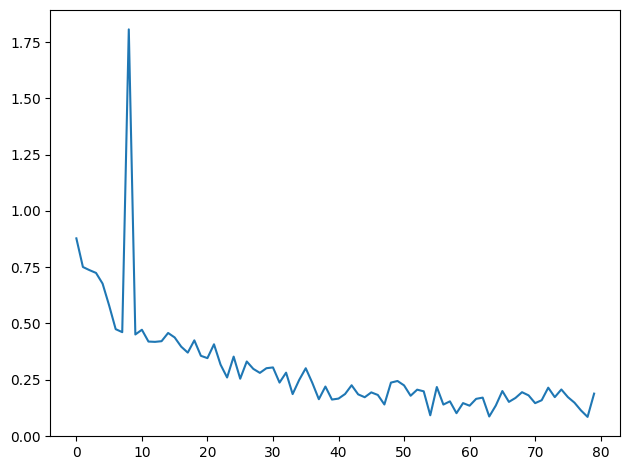

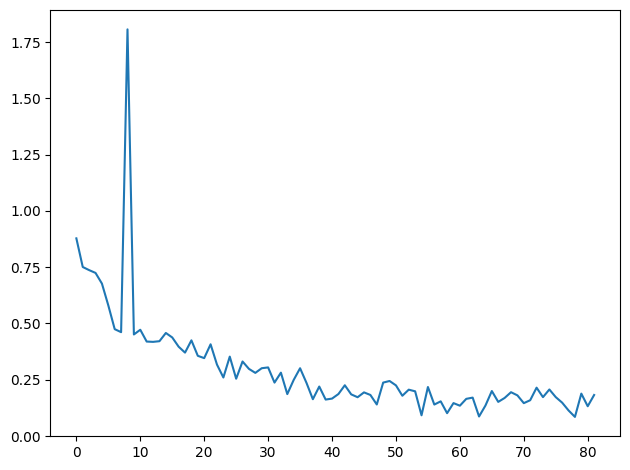

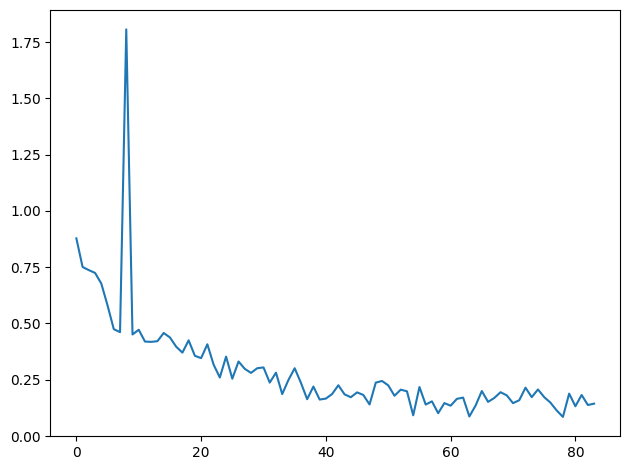

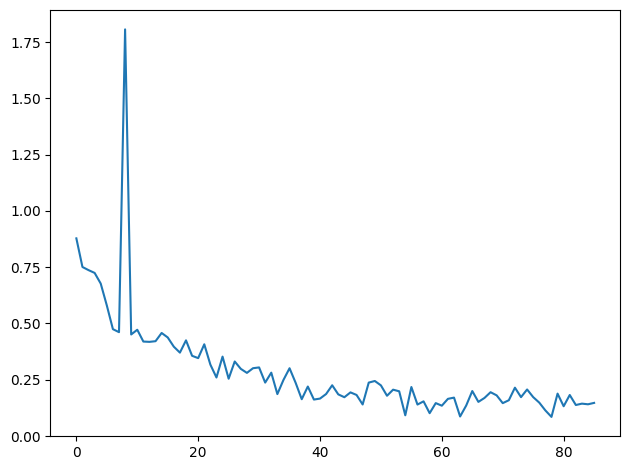

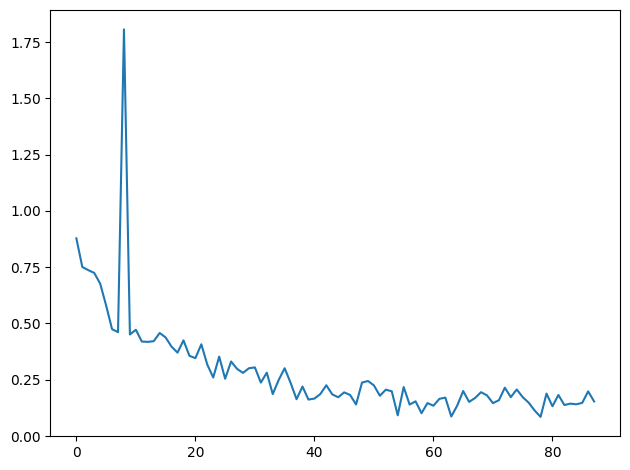

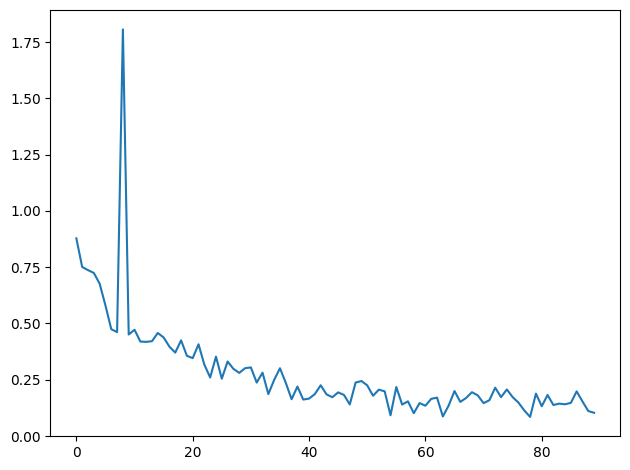

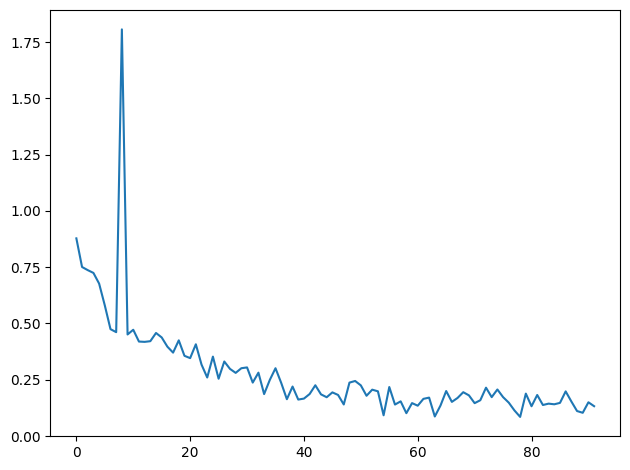

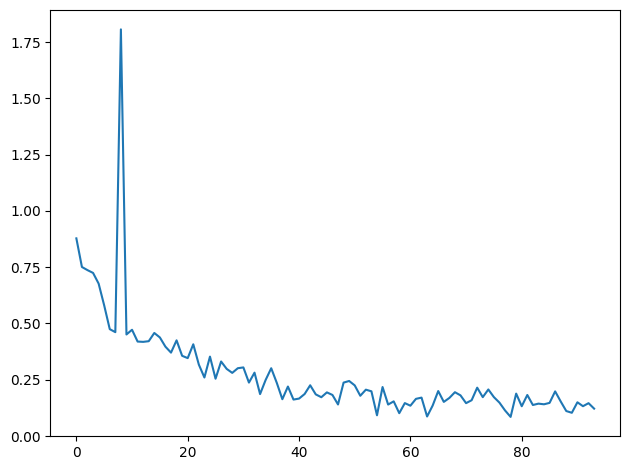

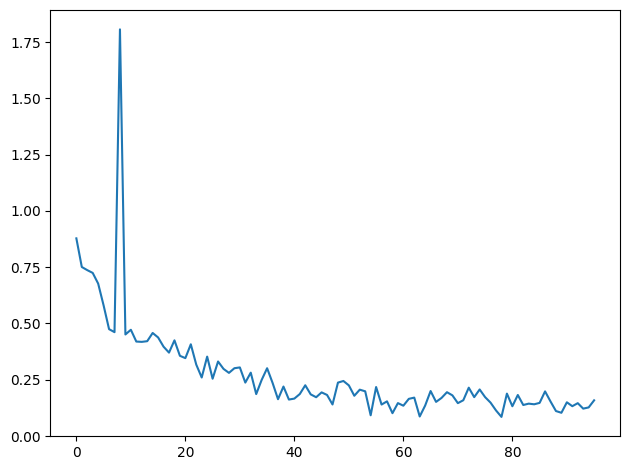

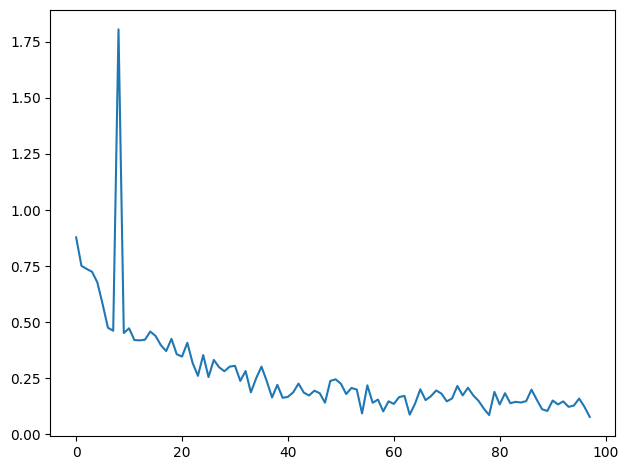

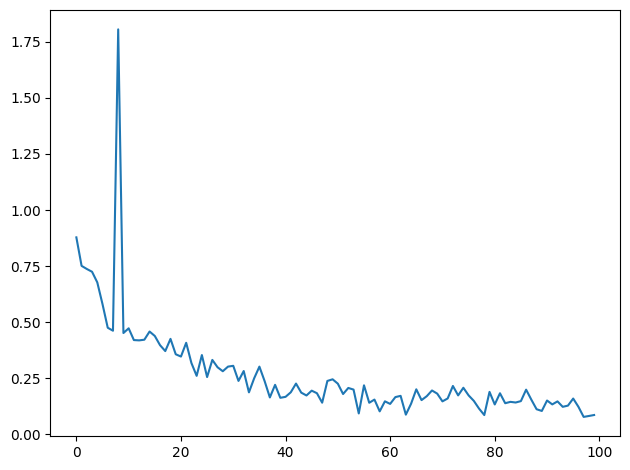

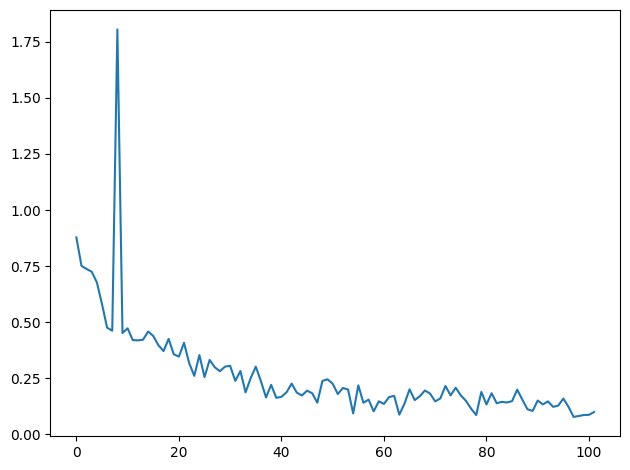

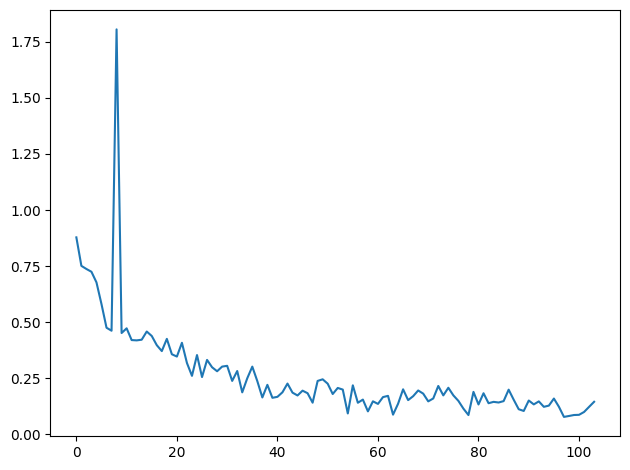

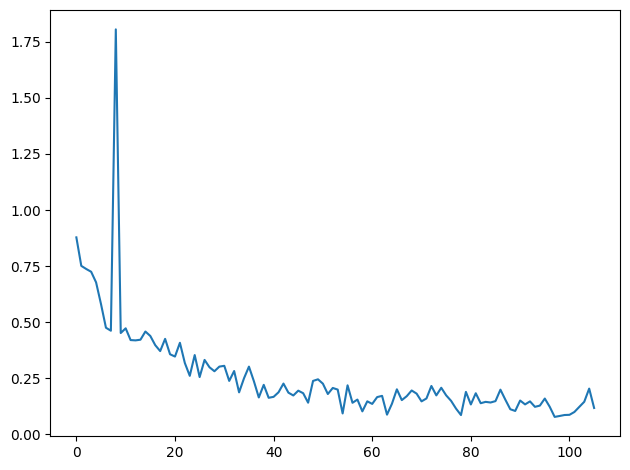

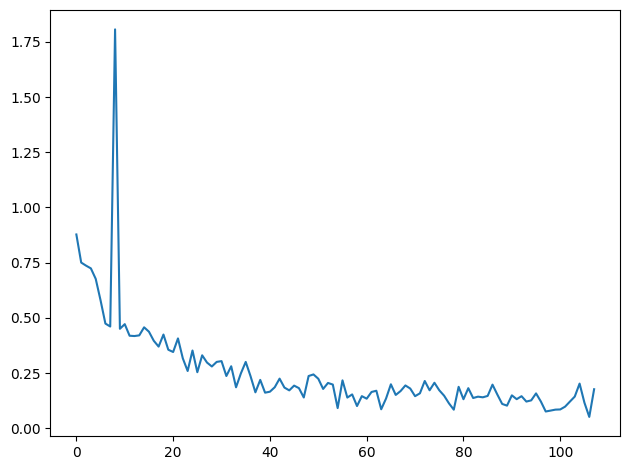

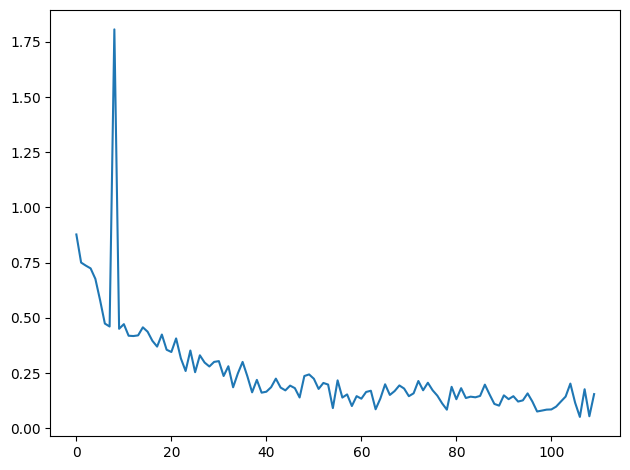

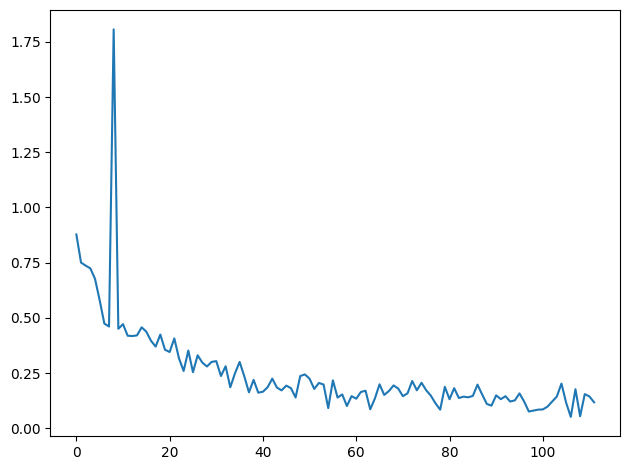

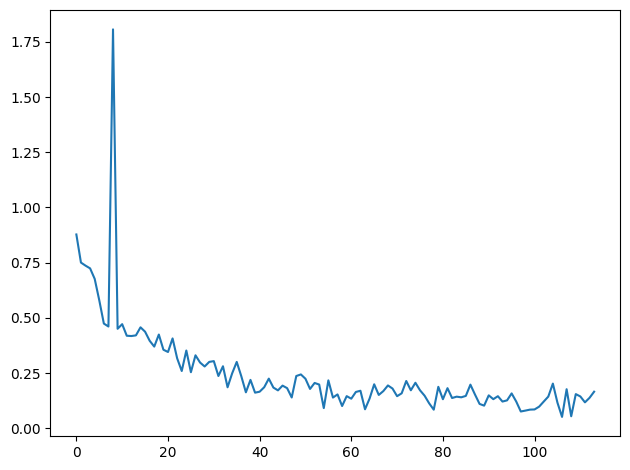

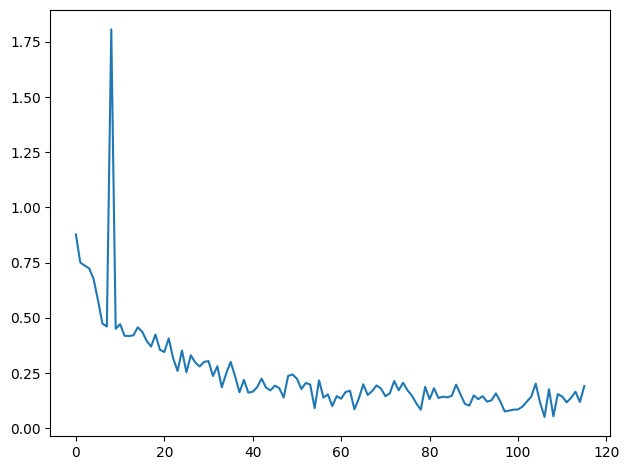

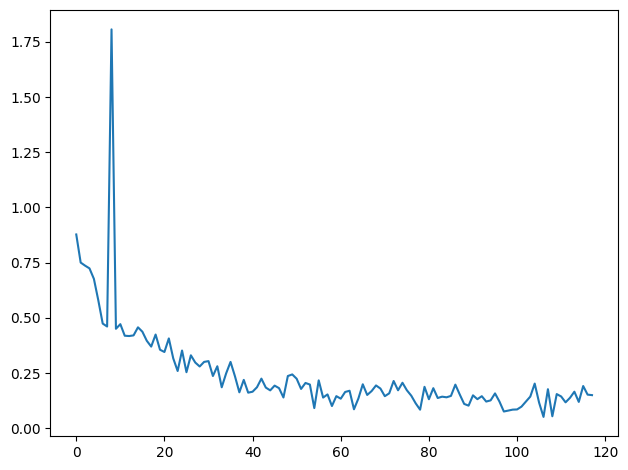

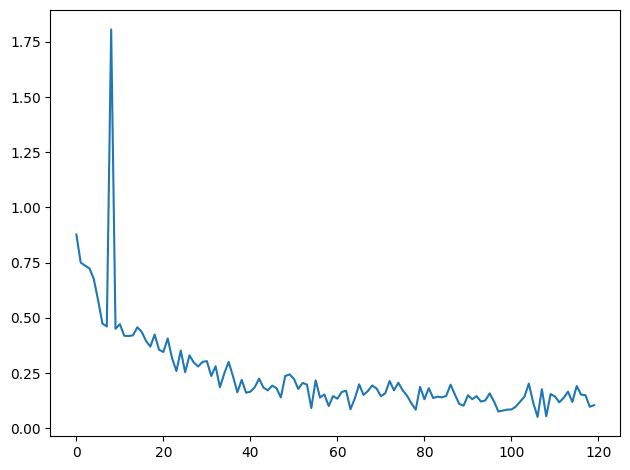

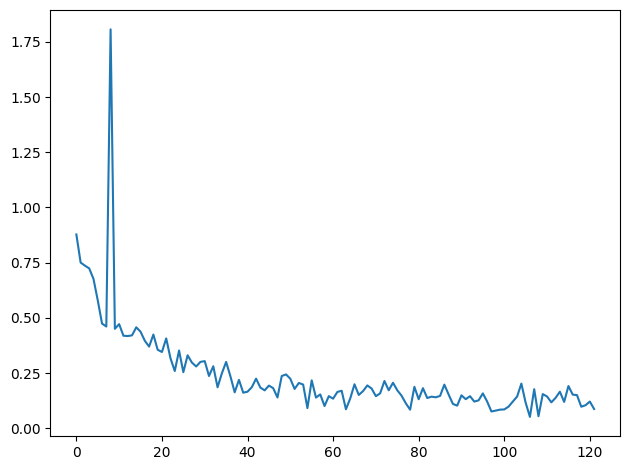

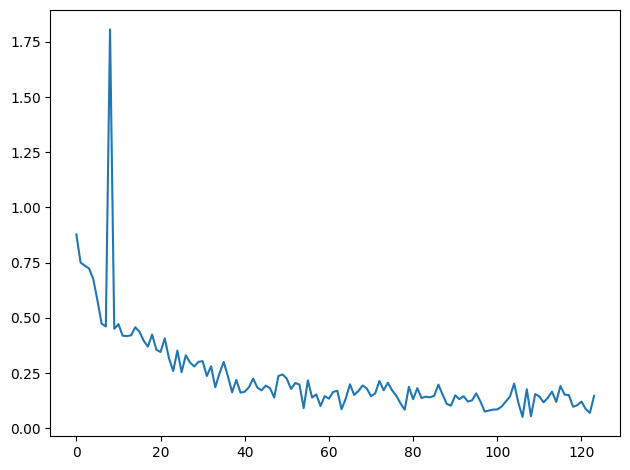

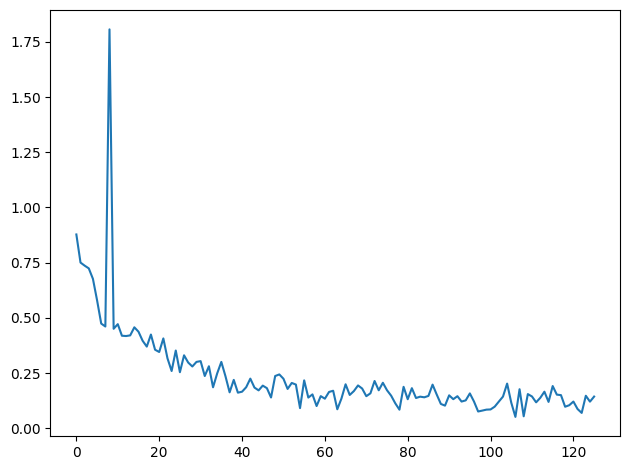

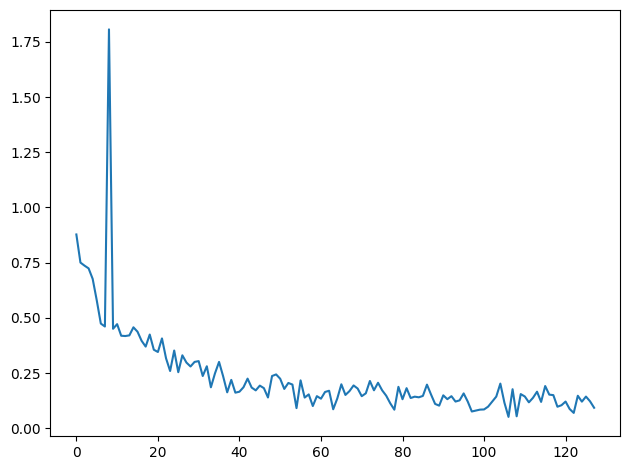

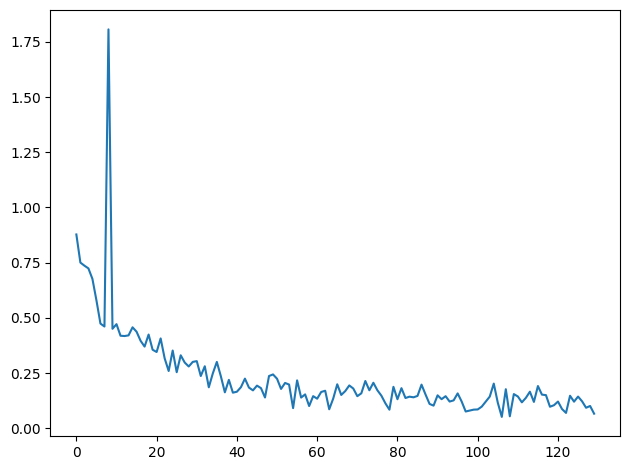

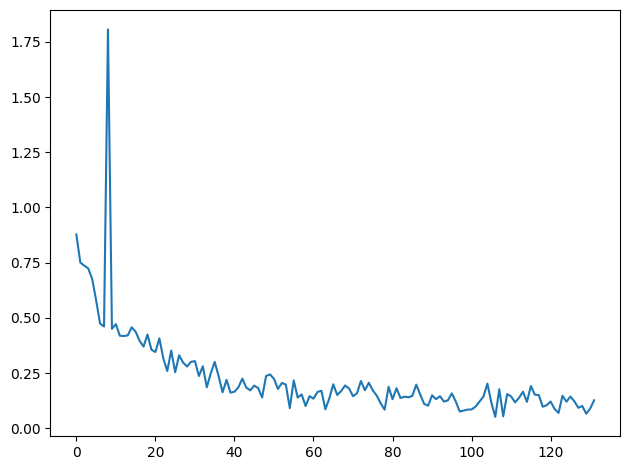

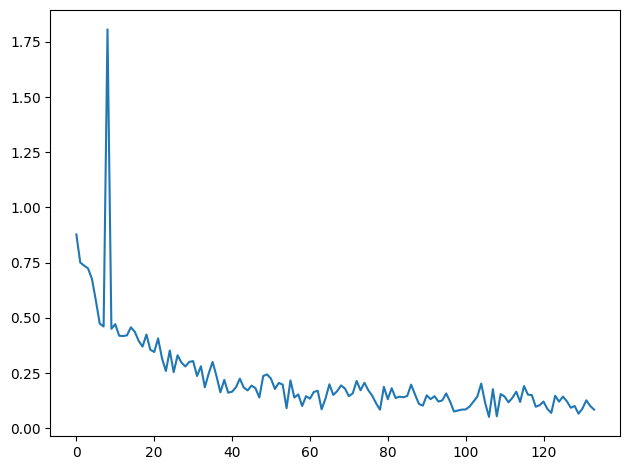

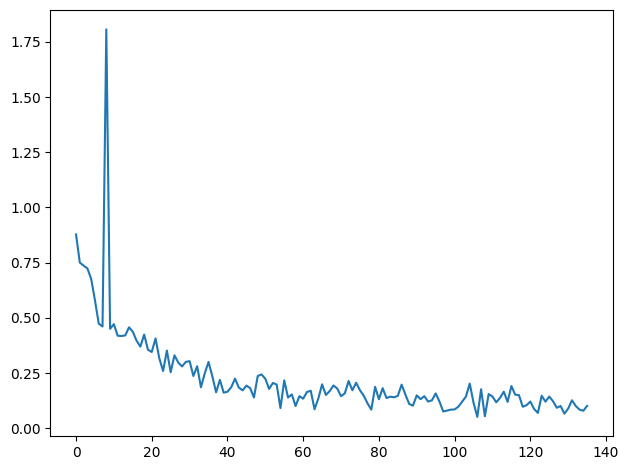

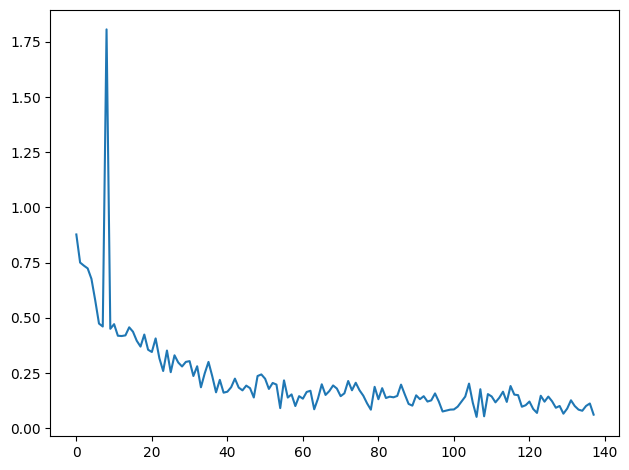

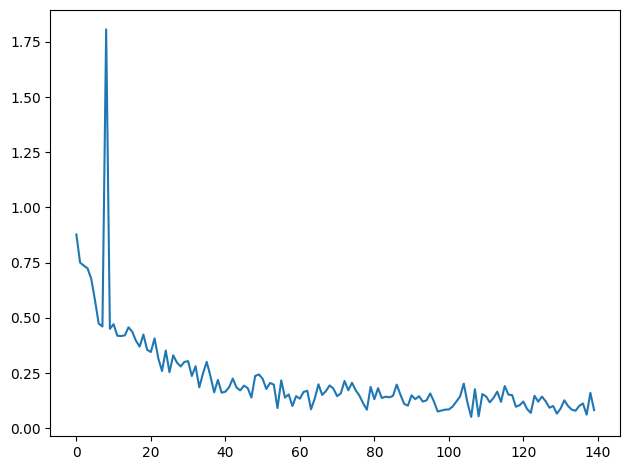

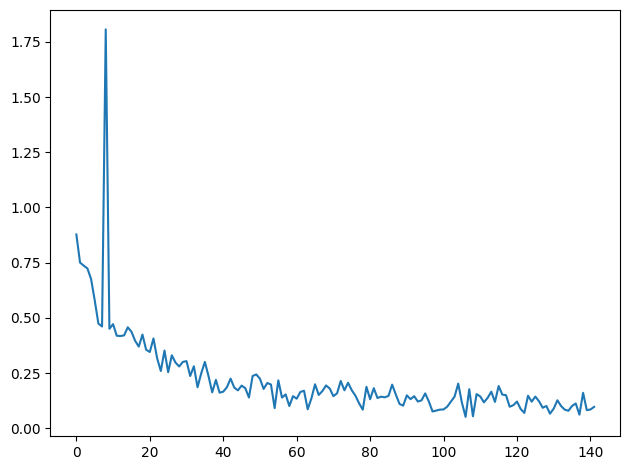

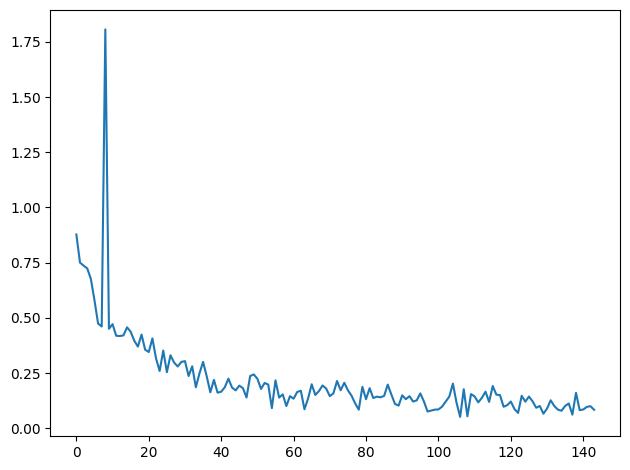

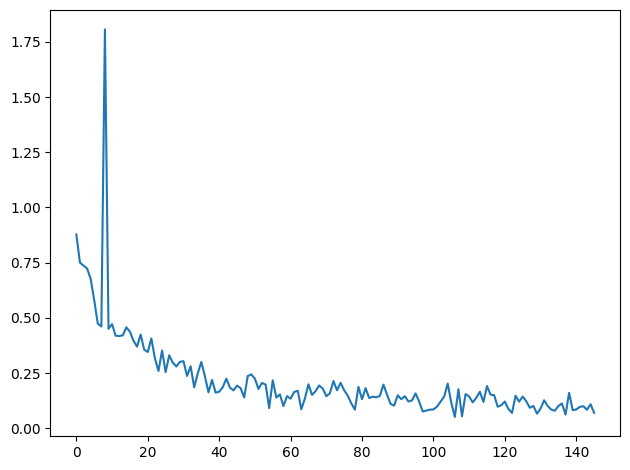

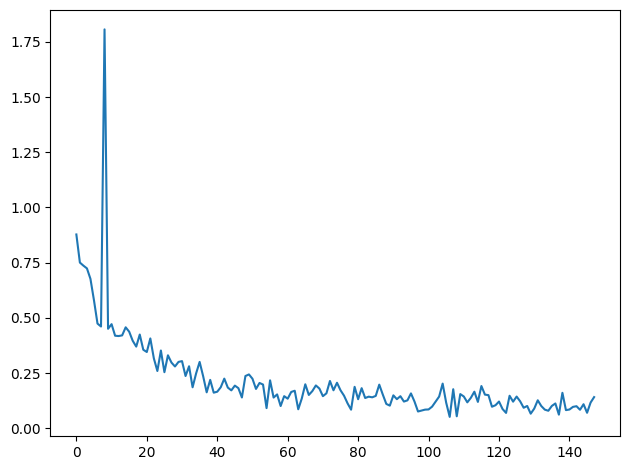

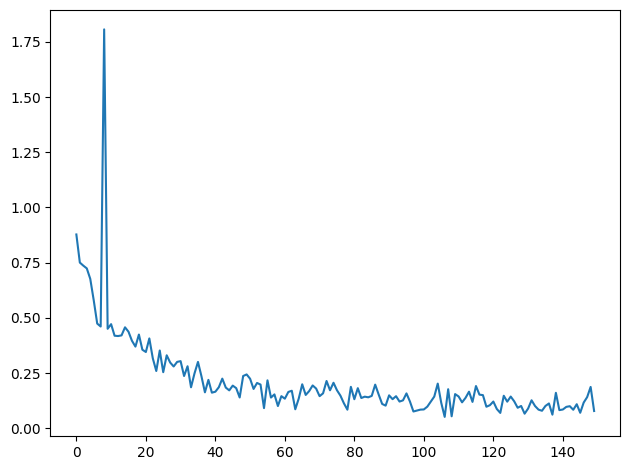

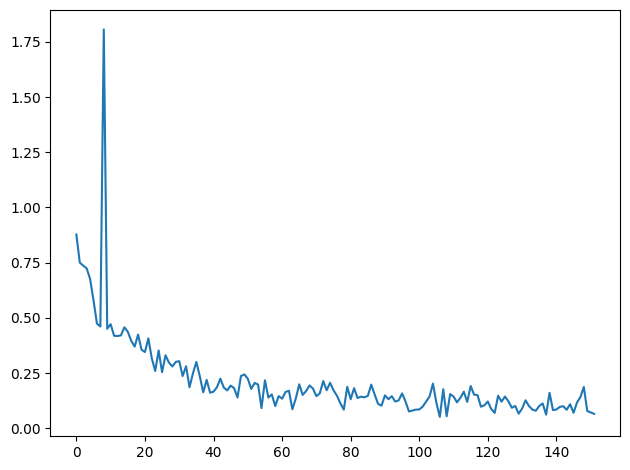

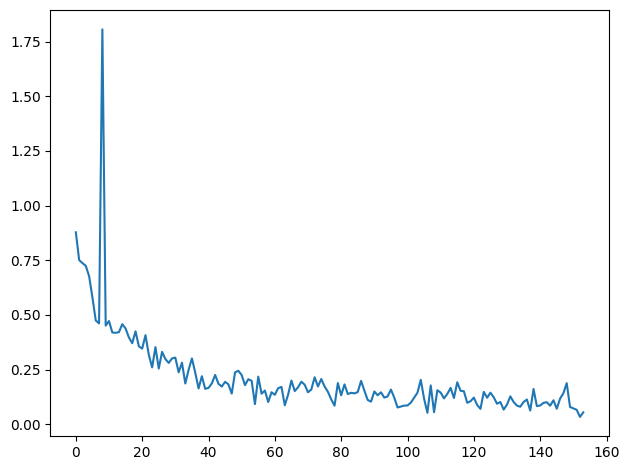

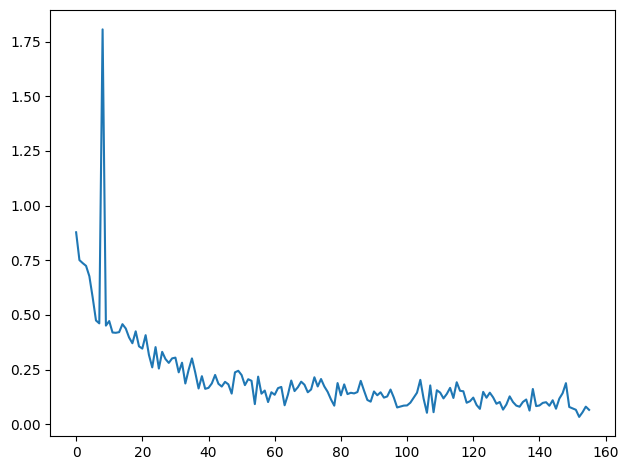

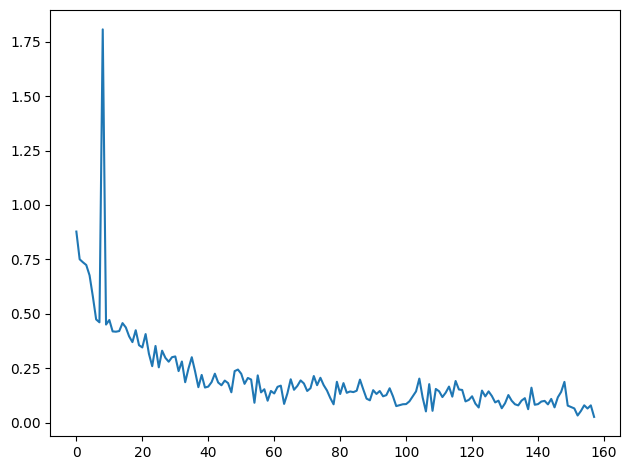

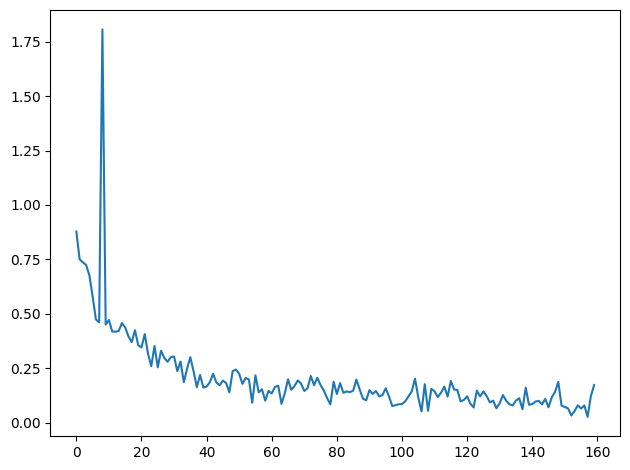

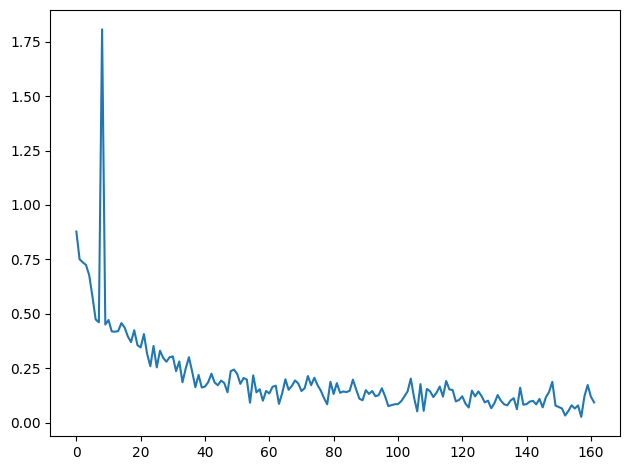

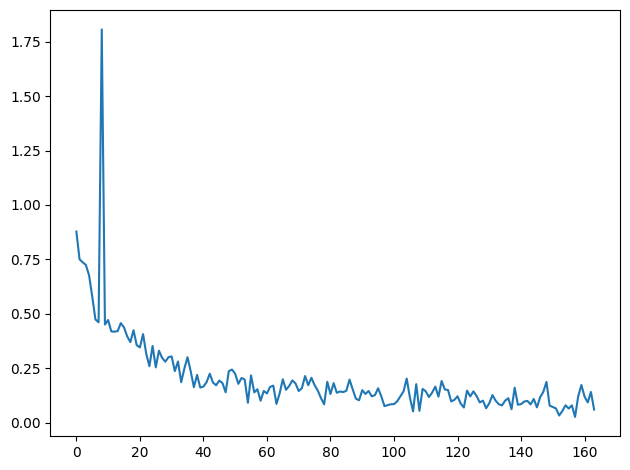

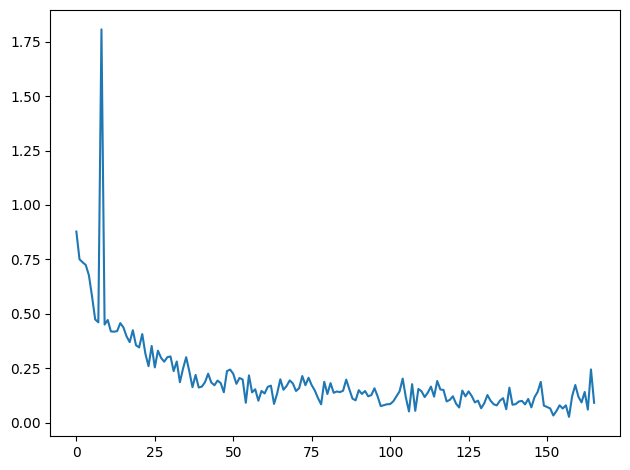

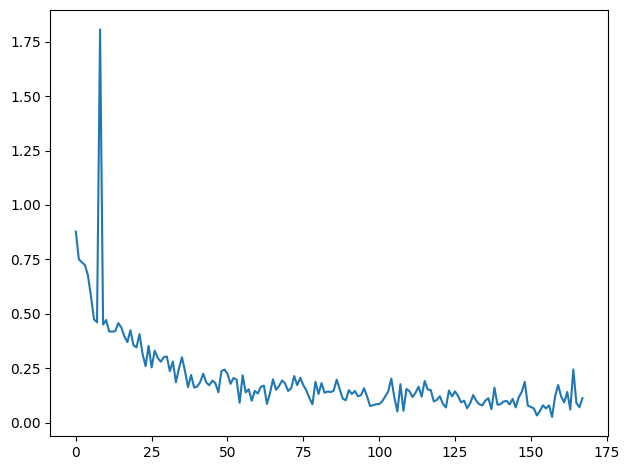

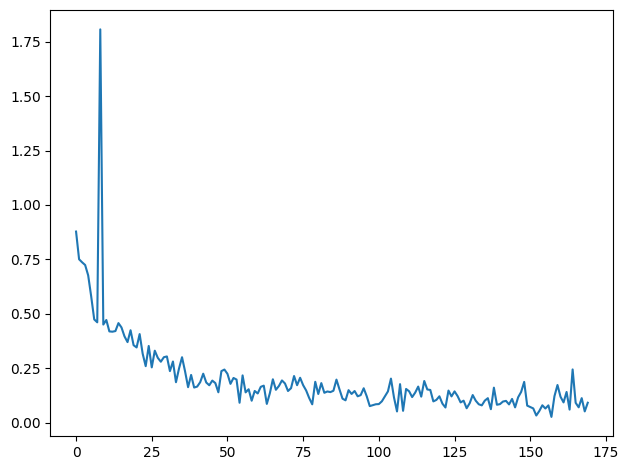

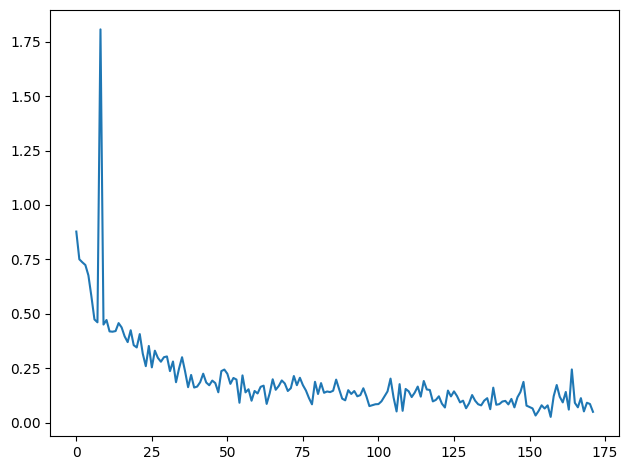

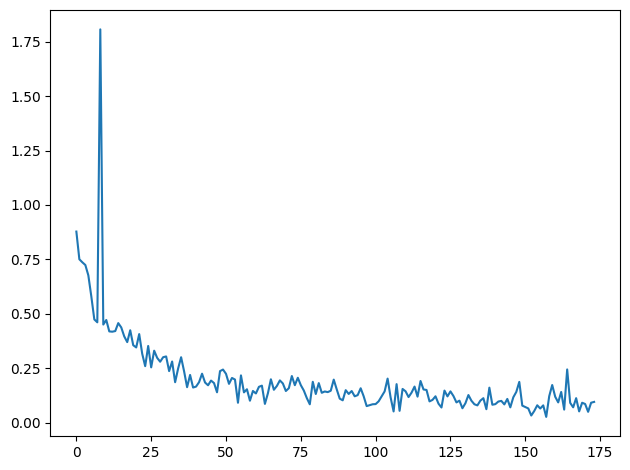

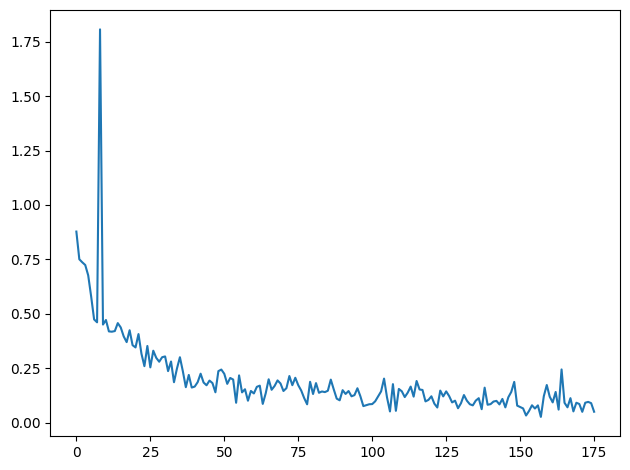

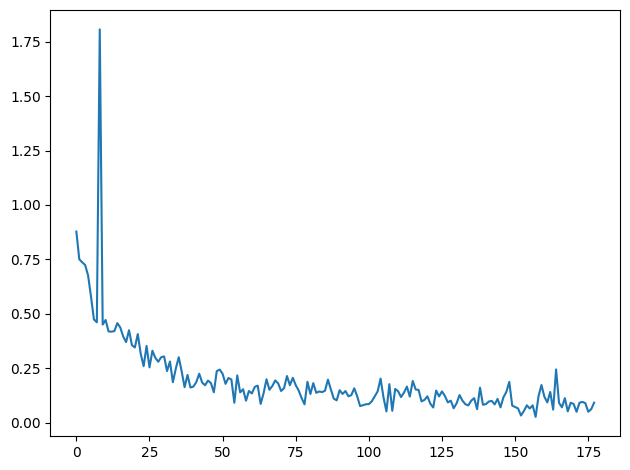

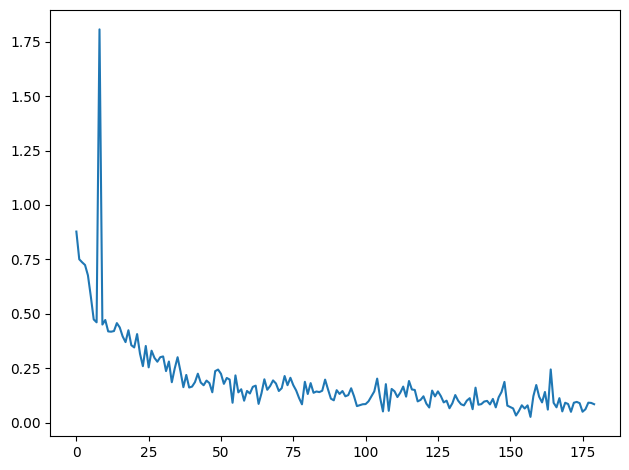

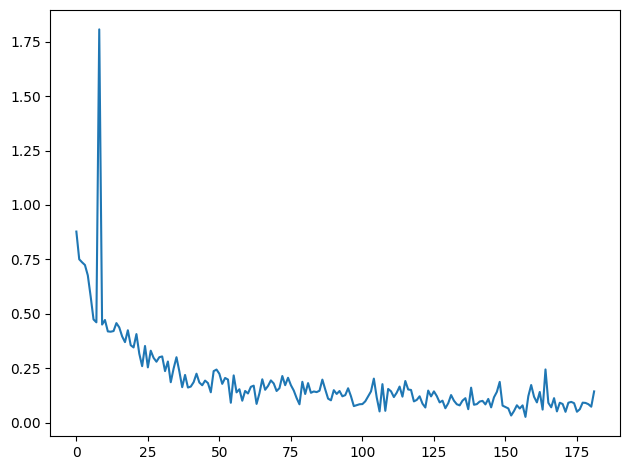

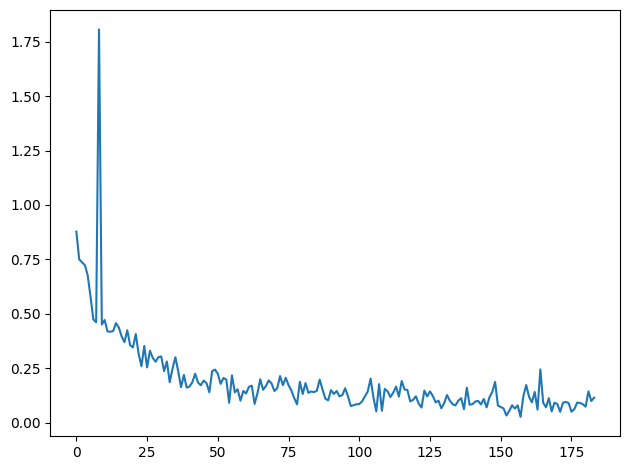

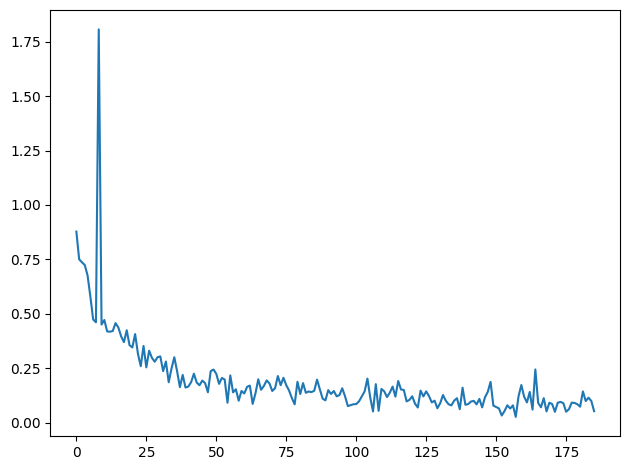

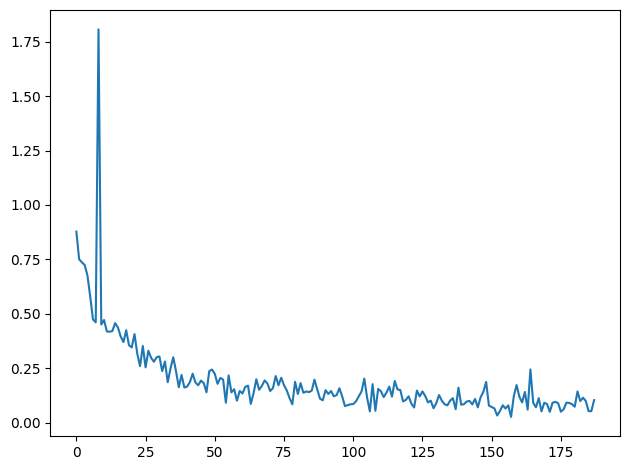

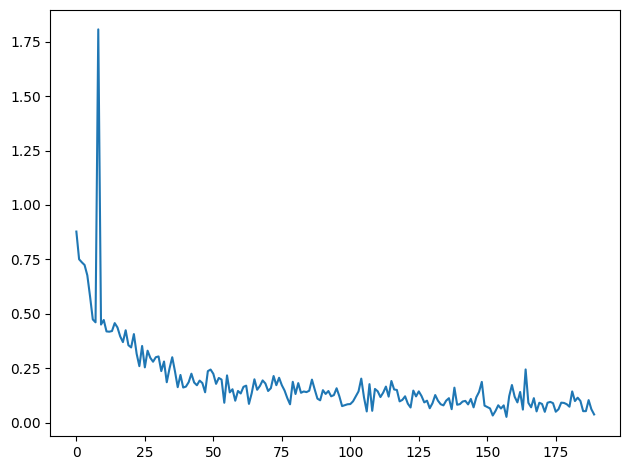

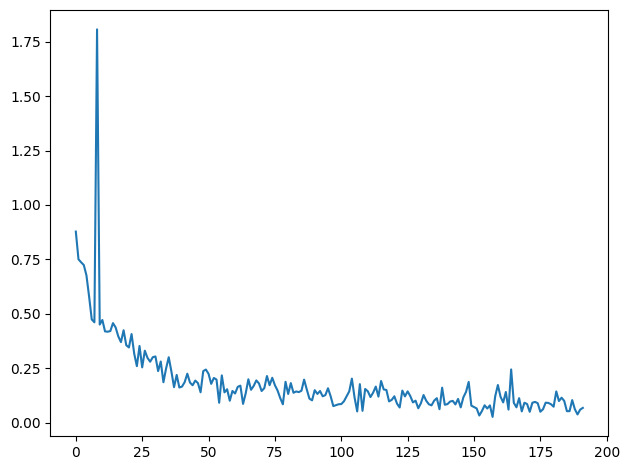

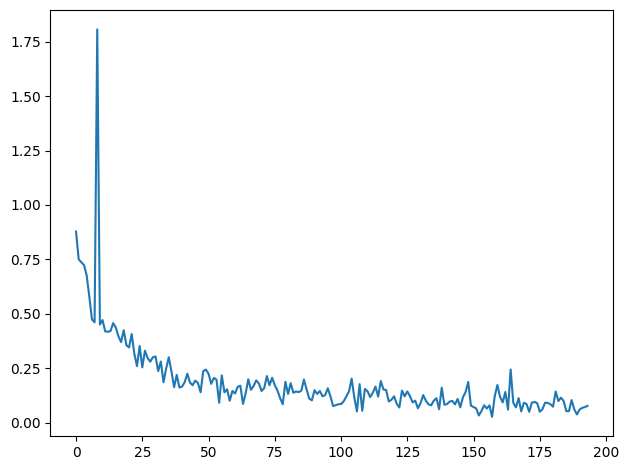

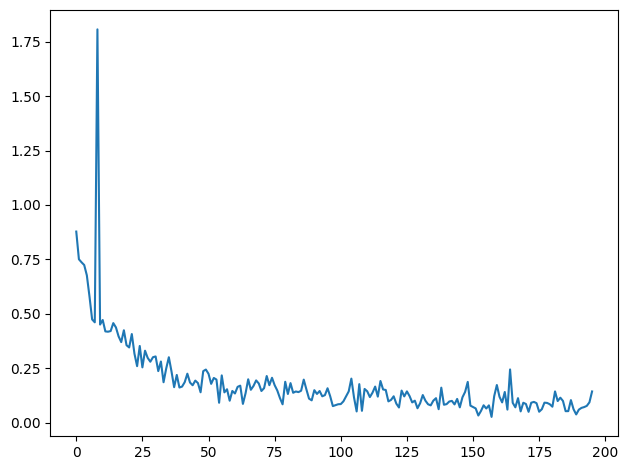

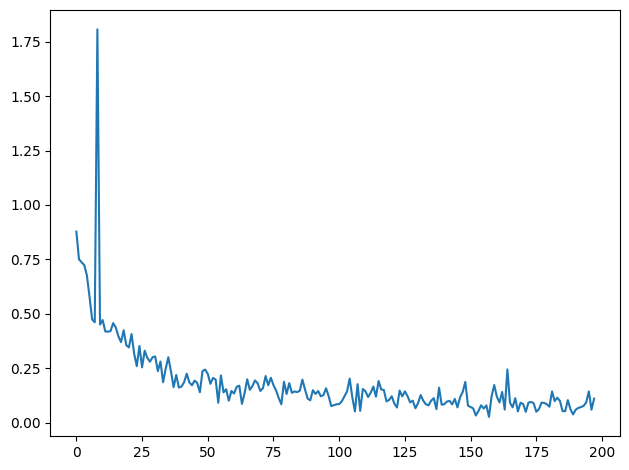

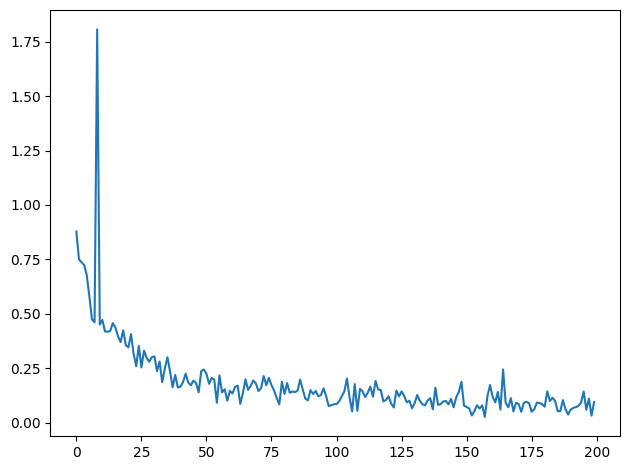

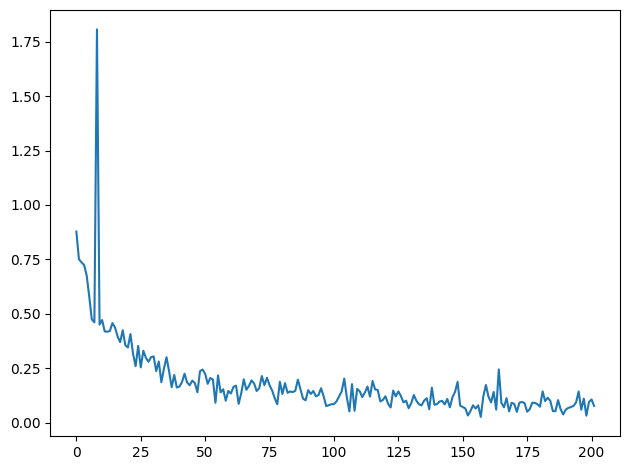

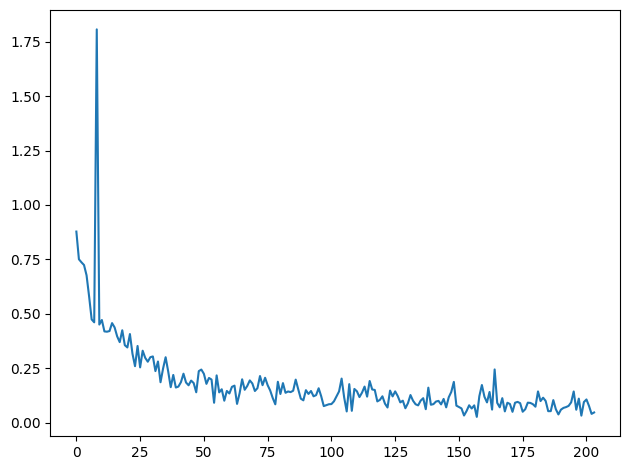

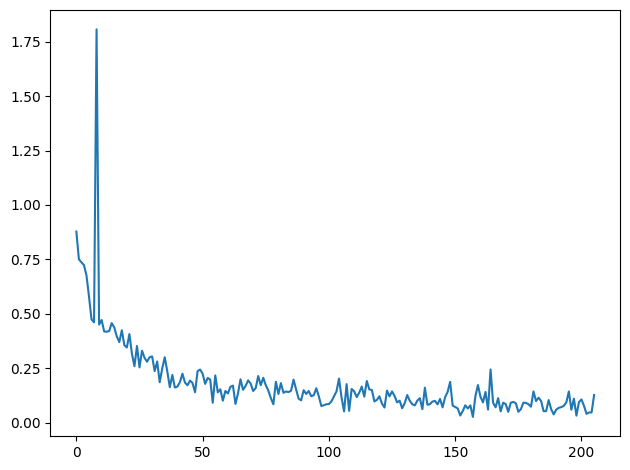

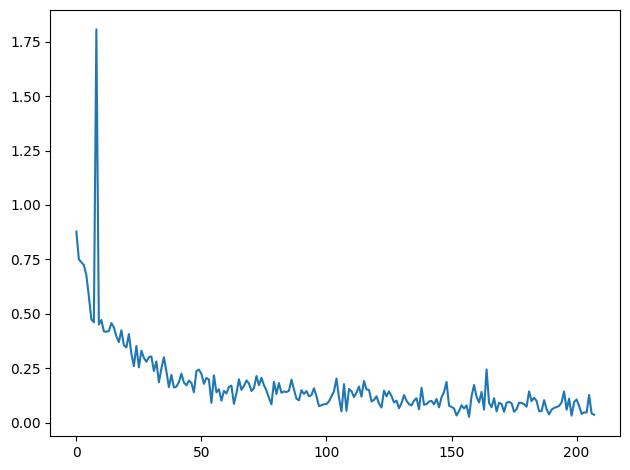

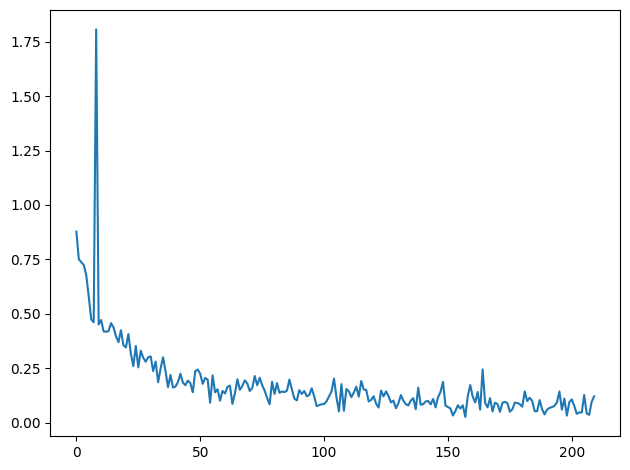

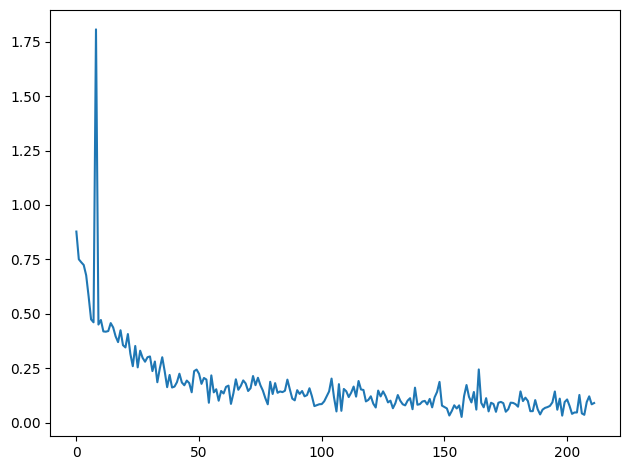

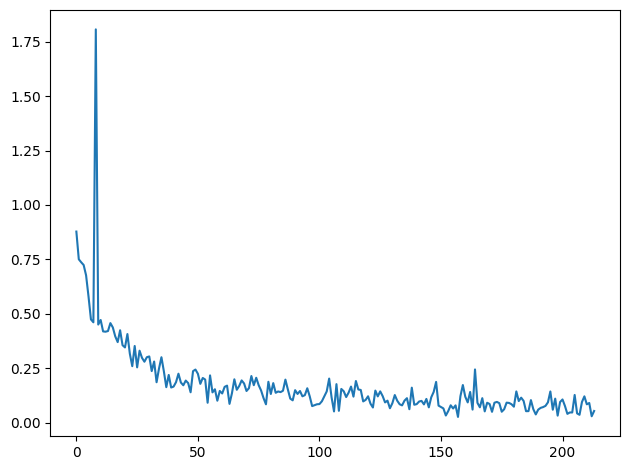

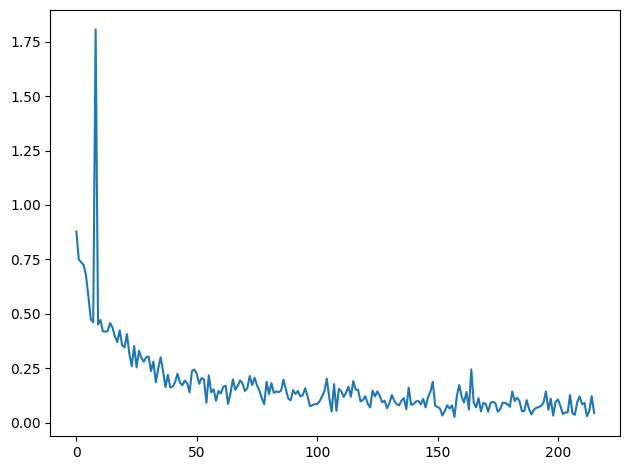

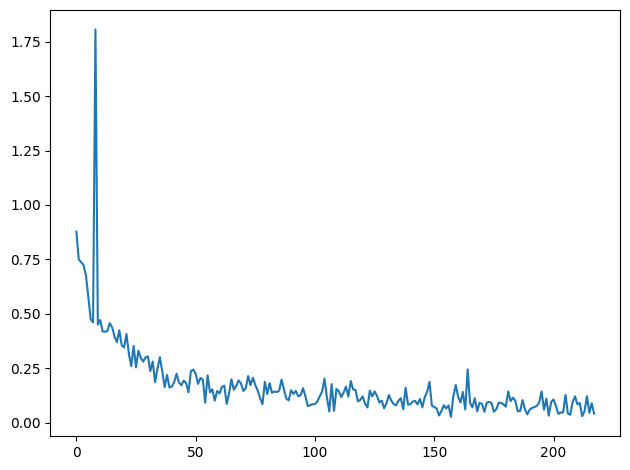

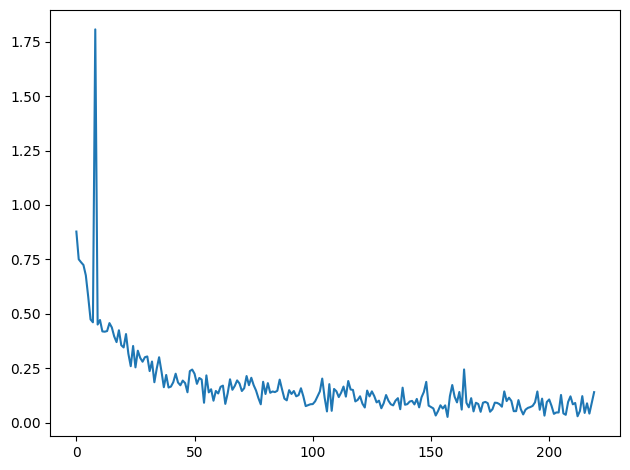

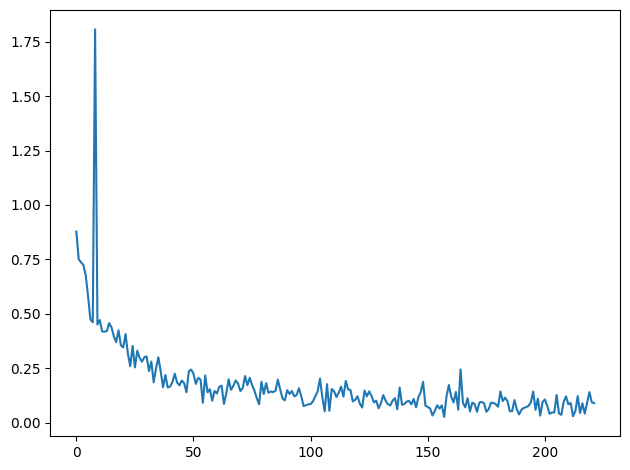

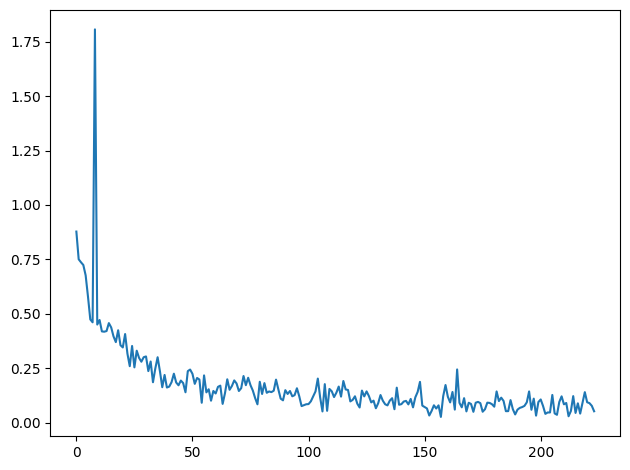

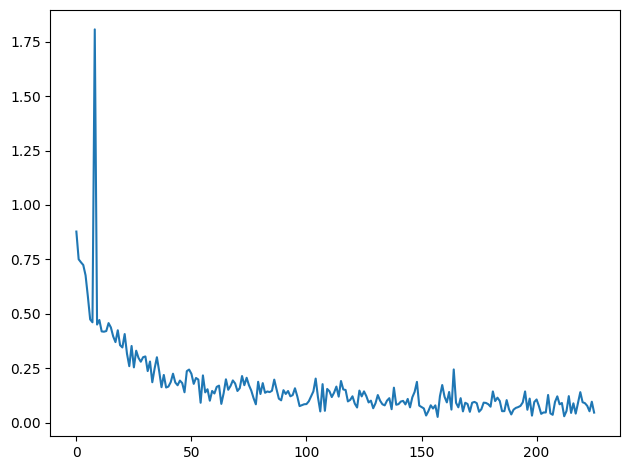

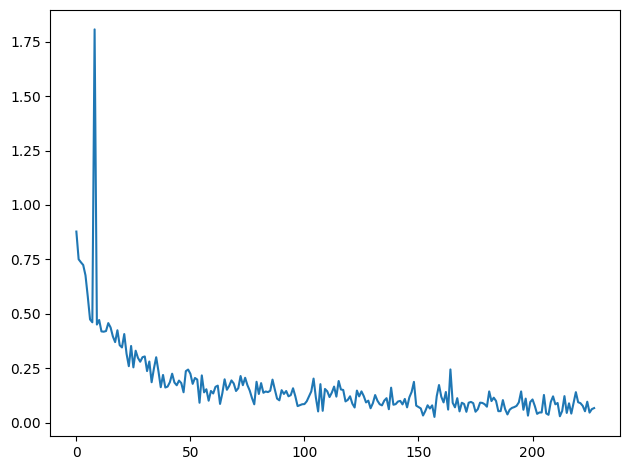

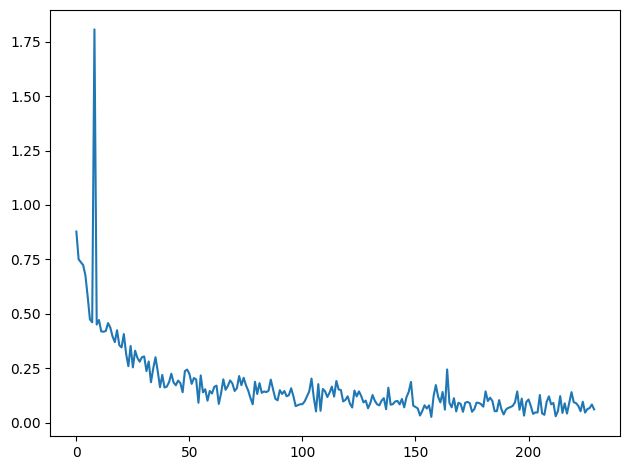

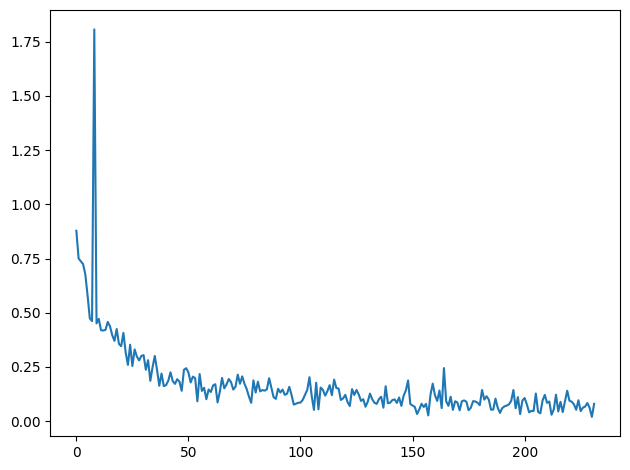

Error in callback <function flush_figures at 0x7ed6d44c5510> (for post_execute):


KeyboardInterrupt: ignored

In [16]:
train_epoch()

In [17]:
model.save('/content/drive/MyDrive/ce_model')